In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)

Files already downloaded and verified


In [3]:
def get_mean_and_std(dataset):
  '''Compute the mean and std value of dataset.'''
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
  mean = torch.zeros(3)
  std = torch.zeros(3)
  print('==> Computing mean and std..')
  for inputs, targets in dataloader:
      for i in range(3):
          mean[i] += inputs[:,i,:,:].mean()
          std[i] += inputs[:,i,:,:].std()
  mean.div_(len(dataset))
  std.div_(len(dataset))
  return mean, std

def load_data(is_train,aug,batch_size):
  dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
#   mean, std = get_mean_and_std(dataset)
#   print(mean, std)
  dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
  return dataloader

batch_size = 256 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6
[[[-0.9147032  -0.38956204  0.0274618  ...  0.01201648  0.18191507
    0.15102442]
  [-0.32778072 -0.03431951  0.10468844 ... -0.21966343  0.1973604
    0.2591417 ]
  [-0.09610081  0.29003236  0.24369638 ... -0.6366873  -0.51312464
   -0.32778072]
  ...
  [ 1.0931895   1.2321974   1.448432   ...  0.22825105  0.66072035
    1.6646665 ]
  [ 1.2013068   1.3248694   1.3866507  ... -0.38956204 -0.17332745
    1.1704161 ]
  [ 1.3866507   1.2785335   1.1549708  ... -0.8529219  -0.8065859
    0.7997283 ]]

 [[-1.2393323  -0.8772444  -0.53089947 ... -0.5151565  -0.3419841
   -0.3419841 ]
  [-0.8142726  -0.6725861  -0.5623854  ... -0.68832904 -0.32624117
   -0.29475525]
  [-0.6411001  -0.42069885 -0.45218474 ... -1.003188   -0.9244732
   -0.76704377]
  ...
  [ 0.57110703  0.6813077   0.9804237  ... -0.21604052  0.19327614
    1.2323109 ]
  [ 0.6025929   0.74427944  0.8229942  ... -0.83001554 -0.68832904
    0.6655647 ]
  [ 0.87022305  0.8072512   0.6340788  ... -1.12913

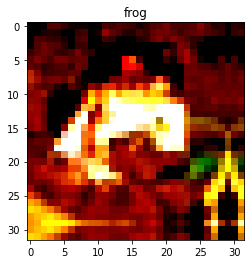

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
image_= np.array(image).copy()
print(image.shape, label)
print(image_)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [5]:
# trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=batch_size,shuffle=True)
# testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=batch_size,shuffle=False)

# images, labels = iter(trainDataLoader).next()
# plt.figure(figsize=(17,8))
# for index in np.arange(0,5):
#   plt.subplot(1,5,index+1)
#   plt.imshow(images[index].numpy().transpose(1,2,0))
#   plt.title(str(classes[labels[index]]))

def get_mean_and_std(dataset):
  '''Compute the mean and std value of dataset.'''
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
  mean = torch.zeros(3)
  std = torch.zeros(3)
  print('==> Computing mean and std..')
  for inputs, targets in dataloader:
      for i in range(3):
          mean[i] += inputs[:,i,:,:].mean()
          std[i] += inputs[:,i,:,:].std()
  mean.div_(len(dataset))
  std.div_(len(dataset))
  return mean, std


In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, in_planes, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = in_planes

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, in_planes, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, in_planes*2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, in_planes*4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, in_planes*8, num_blocks[3], stride=2)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, self.in_planes*8, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
#     return ResNet(BasicBlock, [2, 2, 2])
    return ResNet(64, BasicBlock, [2, 1, 1, 1])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4977226


In [8]:
def adjust_learning_rate(optimizer, current_epoch,max_epoch,lr_min=0,lr_max=0.1,warmup=True):
    warmup_epoch = 10 if warmup else 0
    if current_epoch < warmup_epoch:
        lr = lr_max * current_epoch / warmup_epoch
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [9]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [ ]:
num_epochs = 5000 # param
epoch_start = 0
# path = 'adam_rotate_center_crop1.pt'
# path = 'block_3.pt'
path = 'batch_256_lr_0.1_0.0001_no_crop_decay_0.0001_layer_4.pt'

train_loss_history = []
test_loss_history = []
test_accuracy_history = []
train_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()
lr = 0.1 # param
lr_min=0.0001
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4) # changable optimizer
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9) # changable optimizer
# optimizer = torch.optim.Adam(model1.parameters(),lr=lr, betas=(0.9,0.999), eps=1e-08, amsgrad=False) # changable optimizer
momentum = 0.9
nesterov = True
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov,weight_decay=0.0001)

# torch.cuda.empty_cache()

if os.path.exists(path):
  checkpoint = torch.load(path)
  print('Read model from checkpoint')
  model1.cuda().load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch_start = checkpoint['epoch']
  Loss = checkpoint['Loss']
  train_loss_history = checkpoint['train_loss_history']
  test_loss_history = checkpoint['test_loss_history']
  test_accuracy_history = checkpoint['test_accuracy_history']
  train_accuracy_history = checkpoint['train_accuracy_history']
  print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs + 1):
  timestart = time.time()

  train_loss = 0.0
  test_loss = 0.0
  test_accuracy = 0.0
  train_accuracy = 0.0

  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = model1.cuda()(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    adjust_learning_rate(optimizer=optimizer,current_epoch=epoch,max_epoch=num_epochs,lr_min=lr_min,lr_max=lr,warmup=True)
    optimizer.step()
    train_loss += fit.item()
    train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = model1.cuda()(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
      test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  test_accu = test_accuracy/len(testDataLoader)
  train_accu = train_accuracy/len(trainDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  test_accuracy_history.append(test_accu)
  train_accuracy_history.append(train_accu)
  print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))
  
  if epoch % 5 == 0 and epoch != 0:
    torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'test_accuracy_history':test_accuracy_history,
          'train_accuracy_history':train_accuracy_history},path)
    print('Model saved in epoch %s'%(epoch))

Read model from checkpoint
Restart from epoch 30
Epoch 31, Train loss 0.13584151843144576, Test loss 0.3079941850155592, Train accuracy 95.22161989795919, Test accuracy 90.25390625, Cost 43.231818437576294 s
Epoch 32, Train loss 0.13399849592575006, Test loss 0.3074301704764366, Train accuracy 95.14628507653062, Test accuracy 90.146484375, Cost 42.41968059539795 s
Epoch 33, Train loss 0.12682847306132317, Test loss 0.305640260130167, Train accuracy 95.47951211734694, Test accuracy 90.44921875, Cost 42.42764163017273 s
Epoch 34, Train loss 0.12513558171233352, Test loss 0.32427332662045955, Train accuracy 95.57238520408163, Test accuracy 90.205078125, Cost 42.86748790740967 s
Epoch 35, Train loss 0.12142375925061655, Test loss 0.3071821141988039, Train accuracy 95.80157844387755, Test accuracy 90.546875, Cost 42.978787660598755 s
Model saved in epoch 35
Epoch 36, Train loss 0.11623737913537391, Test loss 0.30505676157772543, Train accuracy 95.88608099489795, Test accuracy 90.44921875, C

Epoch 81, Train loss 0.06438899718757186, Test loss 0.31096380166709425, Train accuracy 97.78738839285714, Test accuracy 90.703125, Cost 42.54138112068176 s
Epoch 82, Train loss 0.06279360661663268, Test loss 0.3304105207324028, Train accuracy 97.79735331632654, Test accuracy 90.83984375, Cost 42.571311473846436 s
Epoch 83, Train loss 0.06849548057177846, Test loss 0.3146196834743023, Train accuracy 97.60722257653062, Test accuracy 91.201171875, Cost 42.41266751289368 s
Epoch 84, Train loss 0.06651825078630022, Test loss 0.33175252825021745, Train accuracy 97.75271045918367, Test accuracy 90.927734375, Cost 42.43761968612671 s
Epoch 85, Train loss 0.07032799587718078, Test loss 0.30878752917051316, Train accuracy 97.59406887755102, Test accuracy 90.87890625, Cost 42.546825647354126 s
Model saved in epoch 85
Epoch 86, Train loss 0.06806654985804035, Test loss 0.30510063506662843, Train accuracy 97.64628507653062, Test accuracy 90.9375, Cost 42.58478236198425 s
Epoch 87, Train loss 0.062

Epoch 132, Train loss 0.05301741665533306, Test loss 0.3276159539818764, Train accuracy 98.1967474489796, Test accuracy 91.142578125, Cost 42.16102933883667 s
Epoch 133, Train loss 0.056102719300483564, Test loss 0.3055511448532343, Train accuracy 98.10586734693878, Test accuracy 91.337890625, Cost 42.43997812271118 s
Epoch 134, Train loss 0.05257694169460815, Test loss 0.3098915882408619, Train accuracy 98.2748724489796, Test accuracy 91.328125, Cost 42.38365316390991 s
Epoch 135, Train loss 0.05946942182181745, Test loss 0.31539942137897015, Train accuracy 97.95838647959184, Test accuracy 91.103515625, Cost 42.334694623947144 s
Model saved in epoch 135
Epoch 136, Train loss 0.05451188025501918, Test loss 0.2973214462399483, Train accuracy 98.16047512755102, Test accuracy 91.4453125, Cost 42.33452820777893 s
Epoch 137, Train loss 0.05525762389166927, Test loss 0.3224340550601482, Train accuracy 98.13456632653062, Test accuracy 91.103515625, Cost 42.73084282875061 s
Epoch 138, Train lo

Epoch 182, Train loss 0.05146659299617215, Test loss 0.2924476083368063, Train accuracy 98.21348852040816, Test accuracy 91.708984375, Cost 42.48094153404236 s
Epoch 183, Train loss 0.04537998724310678, Test loss 0.3044808503240347, Train accuracy 98.47735969387755, Test accuracy 91.796875, Cost 42.34650158882141 s
Epoch 184, Train loss 0.05168825819404149, Test loss 0.33024860098958014, Train accuracy 98.23979591836735, Test accuracy 91.181640625, Cost 42.276636600494385 s
Epoch 185, Train loss 0.04910481768204089, Test loss 0.31050131767988204, Train accuracy 98.37970344387755, Test accuracy 91.689453125, Cost 42.29986572265625 s
Model saved in epoch 185
Epoch 186, Train loss 0.04818135231011072, Test loss 0.3101671613752842, Train accuracy 98.30197704081633, Test accuracy 91.689453125, Cost 42.41011595726013 s
Epoch 187, Train loss 0.058148489637794544, Test loss 0.2935324013233185, Train accuracy 98.04607780612245, Test accuracy 92.001953125, Cost 42.54669189453125 s
Epoch 188, Tra

Epoch 235, Train loss 0.04630916738616569, Test loss 0.30610686764121053, Train accuracy 98.41278698979592, Test accuracy 92.0703125, Cost 42.418078899383545 s
Model saved in epoch 235
Epoch 236, Train loss 0.046218310611094444, Test loss 0.28496140129864217, Train accuracy 98.41677295918367, Test accuracy 92.158203125, Cost 42.42809438705444 s
Epoch 237, Train loss 0.047736084288252253, Test loss 0.29441151581704617, Train accuracy 98.39325573979592, Test accuracy 91.533203125, Cost 42.376739501953125 s
Epoch 238, Train loss 0.04293332618604205, Test loss 0.31308296993374823, Train accuracy 98.5287786989796, Test accuracy 91.69921875, Cost 42.432655334472656 s
Epoch 239, Train loss 0.05480348116870285, Test loss 0.2837000325322151, Train accuracy 98.14373405612245, Test accuracy 91.9921875, Cost 42.36117911338806 s
Epoch 240, Train loss 0.04627360513775933, Test loss 0.2952613435685635, Train accuracy 98.43311543367346, Test accuracy 92.177734375, Cost 42.3250994682312 s
Model saved i

Epoch 285, Train loss 0.04075401467841347, Test loss 0.2920573364943266, Train accuracy 98.64237882653062, Test accuracy 92.392578125, Cost 42.382619857788086 s
Model saved in epoch 285
Epoch 286, Train loss 0.0459394522334392, Test loss 0.3012969557195902, Train accuracy 98.46141581632654, Test accuracy 91.54296875, Cost 42.32610082626343 s
Epoch 287, Train loss 0.05386873723806015, Test loss 0.3279165208339691, Train accuracy 98.15648915816327, Test accuracy 91.103515625, Cost 42.3290274143219 s
Epoch 288, Train loss 0.0550065467001072, Test loss 0.3087876670062542, Train accuracy 98.07557397959184, Test accuracy 91.787109375, Cost 42.28315186500549 s
Epoch 289, Train loss 0.048214631245414516, Test loss 0.2868976376950741, Train accuracy 98.37850765306122, Test accuracy 91.767578125, Cost 42.305176973342896 s
Epoch 290, Train loss 0.04668388778476843, Test loss 0.29997895248234274, Train accuracy 98.41557716836735, Test accuracy 92.1875, Cost 42.31198215484619 s
Model saved in epoch

Epoch 337, Train loss 0.047250379912783295, Test loss 0.29956665076315403, Train accuracy 98.44945790816327, Test accuracy 91.748046875, Cost 42.36430549621582 s
Epoch 338, Train loss 0.04576926570556754, Test loss 0.3021242920309305, Train accuracy 98.47058354591837, Test accuracy 92.158203125, Cost 42.3490149974823 s
Epoch 339, Train loss 0.04448222247788645, Test loss 0.28940166644752024, Train accuracy 98.42753507653062, Test accuracy 92.20703125, Cost 42.328641176223755 s
Epoch 340, Train loss 0.04131387422640561, Test loss 0.308708706125617, Train accuracy 98.60251913265306, Test accuracy 92.275390625, Cost 42.33465361595154 s
Model saved in epoch 340
Epoch 341, Train loss 0.0458859994779436, Test loss 0.3311488915234804, Train accuracy 98.48891900510205, Test accuracy 91.42578125, Cost 42.344120025634766 s
Epoch 342, Train loss 0.04485583537714366, Test loss 0.31067010052502153, Train accuracy 98.52638711734694, Test accuracy 92.0703125, Cost 42.15129780769348 s
Epoch 343, Train

Epoch 387, Train loss 0.04762070657381294, Test loss 0.2818604249507189, Train accuracy 98.40720663265306, Test accuracy 92.548828125, Cost 54.476505756378174 s
Epoch 388, Train loss 0.040329759332294365, Test loss 0.29287684746086595, Train accuracy 98.69180484693878, Test accuracy 91.884765625, Cost 54.24426198005676 s
Epoch 389, Train loss 0.04487201967276633, Test loss 0.29979527108371257, Train accuracy 98.43191964285714, Test accuracy 92.03125, Cost 54.16298055648804 s
Epoch 390, Train loss 0.04497901354773844, Test loss 0.303619659692049, Train accuracy 98.48533163265306, Test accuracy 92.03125, Cost 54.25364017486572 s
Model saved in epoch 390
Epoch 391, Train loss 0.042432440497095186, Test loss 0.3187571868300438, Train accuracy 98.50286989795919, Test accuracy 91.9140625, Cost 54.49328851699829 s
Epoch 392, Train loss 0.041911994639251916, Test loss 0.28144277408719065, Train accuracy 98.58019770408163, Test accuracy 92.470703125, Cost 54.332695960998535 s
Epoch 393, Train l

Epoch 437, Train loss 0.03796962412948511, Test loss 0.2843388207256794, Train accuracy 98.73325892857143, Test accuracy 92.470703125, Cost 54.24945878982544 s
Epoch 438, Train loss 0.04795705410176698, Test loss 0.2943119790405035, Train accuracy 98.35180165816327, Test accuracy 91.982421875, Cost 54.099915742874146 s
Epoch 439, Train loss 0.0394635037233939, Test loss 0.28865429349243643, Train accuracy 98.67625956632654, Test accuracy 92.216796875, Cost 54.12784123420715 s
Epoch 440, Train loss 0.03787249144717899, Test loss 0.2856973670423031, Train accuracy 98.75039859693878, Test accuracy 92.36328125, Cost 54.43041205406189 s
Model saved in epoch 440
Epoch 441, Train loss 0.04340575330377537, Test loss 0.3072435468435287, Train accuracy 98.53515625, Test accuracy 91.923828125, Cost 54.02440094947815 s
Epoch 442, Train loss 0.04198746415501346, Test loss 0.2906421635299921, Train accuracy 98.60530931122449, Test accuracy 92.197265625, Cost 54.161956548690796 s
Epoch 443, Train los

Epoch 487, Train loss 0.046055688344569384, Test loss 0.31373394578695296, Train accuracy 98.43550701530613, Test accuracy 91.767578125, Cost 54.3455114364624 s
Epoch 488, Train loss 0.04889912384429148, Test loss 0.29837236776947973, Train accuracy 98.33745216836735, Test accuracy 92.099609375, Cost 54.16612672805786 s
Epoch 489, Train loss 0.03904358476485905, Test loss 0.27086482010781765, Train accuracy 98.6375956632653, Test accuracy 92.724609375, Cost 54.11834907531738 s
Epoch 490, Train loss 0.040757067297224184, Test loss 0.2832530301064253, Train accuracy 98.62484056122449, Test accuracy 92.2265625, Cost 54.155710220336914 s
Model saved in epoch 490
Epoch 491, Train loss 0.04036633102508376, Test loss 0.3030300084501505, Train accuracy 98.64038584183673, Test accuracy 92.236328125, Cost 54.10692048072815 s
Epoch 492, Train loss 0.04679644813438003, Test loss 0.32902220226824286, Train accuracy 98.39963329081633, Test accuracy 91.787109375, Cost 54.191953897476196 s
Epoch 493, 

Epoch 537, Train loss 0.04233350725939535, Test loss 0.2959051296114922, Train accuracy 98.59654017857143, Test accuracy 92.01171875, Cost 54.220449924468994 s
Epoch 538, Train loss 0.040900231538606543, Test loss 0.30489118620753286, Train accuracy 98.60371492346938, Test accuracy 91.962890625, Cost 54.03354597091675 s
Epoch 539, Train loss 0.04786157895506797, Test loss 0.29092068076133726, Train accuracy 98.3414381377551, Test accuracy 92.16796875, Cost 54.237951040267944 s
Epoch 540, Train loss 0.0408223087481242, Test loss 0.29620829690247774, Train accuracy 98.64437181122449, Test accuracy 92.470703125, Cost 54.02734088897705 s
Model saved in epoch 540
Epoch 541, Train loss 0.0425128901367817, Test loss 0.28672616370022297, Train accuracy 98.59614158163265, Test accuracy 92.412109375, Cost 54.142650842666626 s
Epoch 542, Train loss 0.03944260073464592, Test loss 0.2770675174891949, Train accuracy 98.66629464285714, Test accuracy 92.529296875, Cost 54.0588653087616 s
Epoch 543, Tr

Epoch 587, Train loss 0.040458989115812034, Test loss 0.28936651833355426, Train accuracy 98.6001275510204, Test accuracy 92.34375, Cost 54.22293162345886 s
Epoch 588, Train loss 0.03691985870578459, Test loss 0.2895275346934795, Train accuracy 98.7743144132653, Test accuracy 92.451171875, Cost 54.07141852378845 s
Epoch 589, Train loss 0.04097778166701295, Test loss 0.31095355488359927, Train accuracy 98.6587213010204, Test accuracy 91.787109375, Cost 53.86720585823059 s
Epoch 590, Train loss 0.042412672348662604, Test loss 0.29341286346316336, Train accuracy 98.62364477040816, Test accuracy 92.431640625, Cost 53.82528471946716 s
Model saved in epoch 590
Epoch 591, Train loss 0.04589133670230453, Test loss 0.2781517345458269, Train accuracy 98.43829719387755, Test accuracy 92.802734375, Cost 53.89381957054138 s
Epoch 592, Train loss 0.04226854886878662, Test loss 0.27114897556602957, Train accuracy 98.58019770408163, Test accuracy 92.705078125, Cost 54.3466591835022 s
Epoch 593, Train 

Epoch 637, Train loss 0.04529467426069385, Test loss 0.28585484363138675, Train accuracy 98.47895408163265, Test accuracy 92.158203125, Cost 54.4000678062439 s
Epoch 638, Train loss 0.03866679326878214, Test loss 0.2987146209925413, Train accuracy 98.73046875, Test accuracy 92.109375, Cost 54.15826225280762 s
Epoch 639, Train loss 0.03884672150205897, Test loss 0.31650767028331755, Train accuracy 98.73844068877551, Test accuracy 91.93359375, Cost 54.23176121711731 s
Epoch 640, Train loss 0.04359154628912861, Test loss 0.2761427730321884, Train accuracy 98.53276466836735, Test accuracy 92.255859375, Cost 54.254088401794434 s
Model saved in epoch 640
Epoch 641, Train loss 0.0388304797162739, Test loss 0.2774312239140272, Train accuracy 98.72448979591837, Test accuracy 92.421875, Cost 54.42051959037781 s
Epoch 642, Train loss 0.04347268103298788, Test loss 0.28525088764727113, Train accuracy 98.55070153061224, Test accuracy 92.607421875, Cost 54.09712195396423 s
Epoch 643, Train loss 0.03

Epoch 687, Train loss 0.03935793617132063, Test loss 0.2774070333689451, Train accuracy 98.65672831632654, Test accuracy 92.666015625, Cost 54.3926420211792 s
Epoch 688, Train loss 0.042307505764219225, Test loss 0.28428846746683123, Train accuracy 98.56265943877551, Test accuracy 92.255859375, Cost 54.26605987548828 s
Epoch 689, Train loss 0.03380847357603132, Test loss 0.2853676214814186, Train accuracy 98.89588647959184, Test accuracy 92.40234375, Cost 54.14197659492493 s
Epoch 690, Train loss 0.035984741656907966, Test loss 0.2767923429608345, Train accuracy 98.83569834183673, Test accuracy 92.490234375, Cost 54.47859597206116 s
Model saved in epoch 690
Epoch 691, Train loss 0.031347675852439534, Test loss 0.2720209704712033, Train accuracy 98.97361288265306, Test accuracy 92.75390625, Cost 54.32556986808777 s
Epoch 692, Train loss 0.03240392298428152, Test loss 0.3281657610088587, Train accuracy 98.96085778061224, Test accuracy 91.34765625, Cost 54.215824365615845 s
Epoch 693, Tra

Epoch 737, Train loss 0.03254660218478922, Test loss 0.2946795392781496, Train accuracy 98.87316645408163, Test accuracy 92.431640625, Cost 54.068952560424805 s
Epoch 738, Train loss 0.04159875312458952, Test loss 0.28690058216452596, Train accuracy 98.65832270408163, Test accuracy 92.587890625, Cost 54.07516527175903 s
Epoch 739, Train loss 0.03461293214979601, Test loss 0.2917757622897625, Train accuracy 98.82134885204081, Test accuracy 92.216796875, Cost 54.1650493144989 s
Epoch 740, Train loss 0.03784959722424344, Test loss 0.2811050582677126, Train accuracy 98.76395089285714, Test accuracy 92.51953125, Cost 54.19319200515747 s
Model saved in epoch 740
Epoch 741, Train loss 0.03694599907256055, Test loss 0.2803809829056263, Train accuracy 98.75239158163265, Test accuracy 92.587890625, Cost 53.999207973480225 s
Epoch 742, Train loss 0.03240051954195892, Test loss 0.2928293887525797, Train accuracy 98.88592155612245, Test accuracy 92.51953125, Cost 54.189369916915894 s
Epoch 743, Tra

Epoch 787, Train loss 0.03776572106349073, Test loss 0.28752044923603537, Train accuracy 98.71173469387755, Test accuracy 92.3828125, Cost 54.337661266326904 s
Epoch 788, Train loss 0.0334790903998881, Test loss 0.29184106960892675, Train accuracy 98.83131377551021, Test accuracy 92.490234375, Cost 53.990312576293945 s
Epoch 789, Train loss 0.03284335388963548, Test loss 0.285612216591835, Train accuracy 98.88791454081633, Test accuracy 92.783203125, Cost 54.15489411354065 s
Epoch 790, Train loss 0.033604446045427144, Test loss 0.3252662573009729, Train accuracy 98.86120854591837, Test accuracy 92.12890625, Cost 54.08985471725464 s
Model saved in epoch 790
Epoch 791, Train loss 0.04477812364526397, Test loss 0.29783304743468764, Train accuracy 98.51602359693878, Test accuracy 92.421875, Cost 54.262274742126465 s
Epoch 792, Train loss 0.04112763636346374, Test loss 0.3022391486912966, Train accuracy 98.63879145408163, Test accuracy 92.34375, Cost 54.42316436767578 s
Epoch 793, Train los

Epoch 837, Train loss 0.03559535871050796, Test loss 0.3069463659077883, Train accuracy 98.74322385204081, Test accuracy 92.51953125, Cost 54.200395822525024 s
Epoch 838, Train loss 0.043264370953322064, Test loss 0.2627169951796532, Train accuracy 98.52718431122449, Test accuracy 93.02734375, Cost 54.43867802619934 s
Epoch 839, Train loss 0.036107581688509305, Test loss 0.2912821494042873, Train accuracy 98.78946109693878, Test accuracy 92.587890625, Cost 54.21602487564087 s
Epoch 840, Train loss 0.035872047767043114, Test loss 0.30005850084125996, Train accuracy 98.71611926020408, Test accuracy 92.51953125, Cost 54.34372615814209 s
Model saved in epoch 840
Epoch 841, Train loss 0.034650347034009744, Test loss 0.27637808211147785, Train accuracy 98.89110331632654, Test accuracy 92.822265625, Cost 54.29008173942566 s
Epoch 842, Train loss 0.04238602175728931, Test loss 0.2915507432073355, Train accuracy 98.6148756377551, Test accuracy 92.568359375, Cost 54.436383962631226 s
Epoch 843, 

Epoch 887, Train loss 0.03560143380844015, Test loss 0.28551625497639177, Train accuracy 98.83410395408163, Test accuracy 92.67578125, Cost 54.11984467506409 s
Epoch 888, Train loss 0.03795199484887476, Test loss 0.30347935631871226, Train accuracy 98.71851084183673, Test accuracy 92.05078125, Cost 54.27316927909851 s
Epoch 889, Train loss 0.03762779533815551, Test loss 0.30215025767683984, Train accuracy 98.74561543367346, Test accuracy 92.138671875, Cost 54.25469970703125 s
Epoch 890, Train loss 0.04175952539247062, Test loss 0.28351788520812987, Train accuracy 98.54711415816327, Test accuracy 92.32421875, Cost 54.28565573692322 s
Model saved in epoch 890
Epoch 891, Train loss 0.030921486061427514, Test loss 0.2895892523229122, Train accuracy 98.91980229591837, Test accuracy 92.412109375, Cost 54.27781057357788 s
Epoch 892, Train loss 0.03720670625358364, Test loss 0.30293390080332755, Train accuracy 98.71532206632654, Test accuracy 92.24609375, Cost 54.12992525100708 s
Epoch 893, Tr

Epoch 937, Train loss 0.0388501543879547, Test loss 0.28798573911190034, Train accuracy 98.69658801020408, Test accuracy 92.5390625, Cost 54.30045771598816 s
Epoch 938, Train loss 0.04051090023784461, Test loss 0.28884217590093614, Train accuracy 98.60809948979592, Test accuracy 92.470703125, Cost 54.20776057243347 s
Epoch 939, Train loss 0.036036180327551404, Test loss 0.2663319021463394, Train accuracy 98.78228635204081, Test accuracy 92.8125, Cost 54.14674401283264 s
Epoch 940, Train loss 0.029191871062016154, Test loss 0.26542536094784736, Train accuracy 99.06289859693878, Test accuracy 92.958984375, Cost 54.37899875640869 s
Model saved in epoch 940
Epoch 941, Train loss 0.0347278947913449, Test loss 0.2885982938110828, Train accuracy 98.79902742346938, Test accuracy 92.294921875, Cost 54.22333025932312 s
Epoch 942, Train loss 0.04046957266317414, Test loss 0.2704827882349491, Train accuracy 98.58657525510205, Test accuracy 92.51953125, Cost 54.14026594161987 s
Epoch 943, Train los

Epoch 987, Train loss 0.03616387552429675, Test loss 0.3037432223558426, Train accuracy 98.78946109693878, Test accuracy 92.28515625, Cost 54.269548177719116 s
Epoch 988, Train loss 0.03728406240080236, Test loss 0.30126005262136457, Train accuracy 98.71412627551021, Test accuracy 92.314453125, Cost 53.997268199920654 s
Epoch 989, Train loss 0.0359709305256339, Test loss 0.27863221392035487, Train accuracy 98.76395089285714, Test accuracy 92.6171875, Cost 54.02528214454651 s
Epoch 990, Train loss 0.03861258804265942, Test loss 0.3191973987966776, Train accuracy 98.74880420918367, Test accuracy 92.138671875, Cost 54.17655038833618 s
Model saved in epoch 990
Epoch 991, Train loss 0.04414848274817424, Test loss 0.2895598739385605, Train accuracy 98.47297512755102, Test accuracy 92.1484375, Cost 54.130768060684204 s
Epoch 992, Train loss 0.03727075976927822, Test loss 0.2919242329895496, Train accuracy 98.74800701530613, Test accuracy 92.32421875, Cost 54.19163799285889 s
Epoch 993, Train 

Epoch 1037, Train loss 0.035447675264345446, Test loss 0.27302911430597304, Train accuracy 98.80141900510205, Test accuracy 92.783203125, Cost 55.35989260673523 s
Epoch 1038, Train loss 0.03452913524411923, Test loss 0.2970633594319224, Train accuracy 98.84167729591837, Test accuracy 92.275390625, Cost 55.242414474487305 s
Epoch 1039, Train loss 0.033806990582628975, Test loss 0.27048231549561025, Train accuracy 98.90385841836735, Test accuracy 92.646484375, Cost 55.310595750808716 s
Epoch 1040, Train loss 0.03163578543973593, Test loss 0.2902105748653412, Train accuracy 98.96763392857143, Test accuracy 92.32421875, Cost 55.34432768821716 s
Model saved in epoch 1040
Epoch 1041, Train loss 0.027309030180378835, Test loss 0.28045592792332175, Train accuracy 99.10475127551021, Test accuracy 92.87109375, Cost 55.276795625686646 s
Epoch 1042, Train loss 0.034784323424195907, Test loss 0.27438461892306804, Train accuracy 98.79982461734694, Test accuracy 92.83203125, Cost 55.417580366134644 s

Epoch 1087, Train loss 0.0343346409475887, Test loss 0.2841944631189108, Train accuracy 98.89548788265306, Test accuracy 92.6953125, Cost 54.68615174293518 s
Epoch 1088, Train loss 0.03541477837086636, Test loss 0.3043329183012247, Train accuracy 98.85004783163265, Test accuracy 92.138671875, Cost 54.7734489440918 s
Epoch 1089, Train loss 0.04160305144198771, Test loss 0.2867109552025795, Train accuracy 98.59693877551021, Test accuracy 92.4609375, Cost 54.9354031085968 s
Epoch 1090, Train loss 0.03127901592738546, Test loss 0.3066623818129301, Train accuracy 98.92538265306122, Test accuracy 92.021484375, Cost 54.599234104156494 s
Model saved in epoch 1090
Epoch 1091, Train loss 0.03468302721442769, Test loss 0.31084868535399435, Train accuracy 98.8038105867347, Test accuracy 92.16796875, Cost 54.341071128845215 s
Epoch 1092, Train loss 0.0292697195937781, Test loss 0.28648953754454853, Train accuracy 99.03938137755102, Test accuracy 92.5, Cost 54.72260046005249 s
Epoch 1093, Train loss

Epoch 1137, Train loss 0.03158535763421761, Test loss 0.29244783595204354, Train accuracy 98.97361288265306, Test accuracy 92.470703125, Cost 54.20568633079529 s
Epoch 1138, Train loss 0.03557171449492857, Test loss 0.2843439273536205, Train accuracy 98.85961415816327, Test accuracy 92.75390625, Cost 54.22556471824646 s
Epoch 1139, Train loss 0.026666032578035886, Test loss 0.2885373167693615, Train accuracy 99.1390306122449, Test accuracy 92.509765625, Cost 54.18021774291992 s
Epoch 1140, Train loss 0.02842772523017258, Test loss 0.2980441730469465, Train accuracy 99.08083545918367, Test accuracy 92.44140625, Cost 54.00353741645813 s
Model saved in epoch 1140
Epoch 1141, Train loss 0.03217763122294706, Test loss 0.29048427008092403, Train accuracy 98.92299107142857, Test accuracy 92.333984375, Cost 53.94945454597473 s
Epoch 1142, Train loss 0.03575477846993171, Test loss 0.30272052697837354, Train accuracy 98.79424426020408, Test accuracy 92.216796875, Cost 54.36479997634888 s
Epoch 1

Epoch 1187, Train loss 0.03158822852158349, Test loss 0.29070825278759005, Train accuracy 99.05492665816327, Test accuracy 92.666015625, Cost 54.057488441467285 s
Epoch 1188, Train loss 0.031319142447556465, Test loss 0.2729793854057789, Train accuracy 98.97680165816327, Test accuracy 92.890625, Cost 54.35333061218262 s
Epoch 1189, Train loss 0.03238861436946128, Test loss 0.2807206679135561, Train accuracy 98.92777423469387, Test accuracy 92.36328125, Cost 54.259464263916016 s
Epoch 1190, Train loss 0.029228713619997914, Test loss 0.28447754867374897, Train accuracy 99.03938137755102, Test accuracy 92.705078125, Cost 54.14775013923645 s
Model saved in epoch 1190
Epoch 1191, Train loss 0.030562084965284307, Test loss 0.3016909033060074, Train accuracy 98.96125637755102, Test accuracy 92.24609375, Cost 54.184621810913086 s
Epoch 1192, Train loss 0.035652381310961684, Test loss 0.2683008275926113, Train accuracy 98.81776147959184, Test accuracy 93.037109375, Cost 54.197293758392334 s
Epo

Epoch 1237, Train loss 0.03154477914225082, Test loss 0.2692431140691042, Train accuracy 98.96922831632654, Test accuracy 93.06640625, Cost 54.37675595283508 s
Epoch 1238, Train loss 0.030912258412822018, Test loss 0.2955779418349266, Train accuracy 98.92976721938776, Test accuracy 92.314453125, Cost 54.303797006607056 s
Epoch 1239, Train loss 0.03314065246139558, Test loss 0.3048674173653126, Train accuracy 98.89947385204081, Test accuracy 92.2265625, Cost 54.13669943809509 s
Epoch 1240, Train loss 0.033086086262245566, Test loss 0.2869145769625902, Train accuracy 98.8655931122449, Test accuracy 92.3046875, Cost 54.19286513328552 s
Model saved in epoch 1240
Epoch 1241, Train loss 0.031432650242076844, Test loss 0.29488995037972926, Train accuracy 98.93973214285714, Test accuracy 92.75390625, Cost 54.2859845161438 s
Epoch 1242, Train loss 0.037271442115116786, Test loss 0.29738274663686753, Train accuracy 98.72528698979592, Test accuracy 92.724609375, Cost 54.262200593948364 s
Epoch 12

Epoch 1287, Train loss 0.029719672453285634, Test loss 0.2753141727298498, Train accuracy 98.98477359693878, Test accuracy 92.705078125, Cost 54.58202028274536 s
Epoch 1288, Train loss 0.0372405623285366, Test loss 0.31317741647362707, Train accuracy 98.78188775510205, Test accuracy 92.3828125, Cost 54.50271439552307 s
Epoch 1289, Train loss 0.028356732472739354, Test loss 0.2903536934405565, Train accuracy 99.09398915816327, Test accuracy 92.490234375, Cost 54.376933574676514 s
Epoch 1290, Train loss 0.03600775571635031, Test loss 0.28905901238322257, Train accuracy 98.8038105867347, Test accuracy 92.3828125, Cost 54.53947734832764 s
Model saved in epoch 1290
Epoch 1291, Train loss 0.03677320891126458, Test loss 0.2938955776393414, Train accuracy 98.72209821428571, Test accuracy 92.109375, Cost 54.44020199775696 s
Epoch 1292, Train loss 0.031123060547765726, Test loss 0.2908644273877144, Train accuracy 99.02702487244898, Test accuracy 92.51953125, Cost 54.39639592170715 s
Epoch 1293, 

Epoch 1337, Train loss 0.03494712202192037, Test loss 0.27458876222372053, Train accuracy 98.81736288265306, Test accuracy 92.7734375, Cost 54.45360803604126 s
Epoch 1338, Train loss 0.0281252136872131, Test loss 0.28453969210386276, Train accuracy 99.0884088010204, Test accuracy 92.451171875, Cost 54.437172174453735 s
Epoch 1339, Train loss 0.029187967687160993, Test loss 0.2856877040117979, Train accuracy 99.03858418367346, Test accuracy 92.861328125, Cost 54.33635687828064 s
Epoch 1340, Train loss 0.031224365540951187, Test loss 0.2943874465301633, Train accuracy 98.97321428571429, Test accuracy 92.36328125, Cost 54.38879585266113 s
Model saved in epoch 1340
Epoch 1341, Train loss 0.03421714856783498, Test loss 0.2771796651184559, Train accuracy 98.8297193877551, Test accuracy 92.51953125, Cost 54.26957869529724 s
Epoch 1342, Train loss 0.03649725657602658, Test loss 0.28010272365063427, Train accuracy 98.76594387755102, Test accuracy 92.67578125, Cost 54.04846930503845 s
Epoch 1343

Epoch 1387, Train loss 0.03643990995134322, Test loss 0.30725860930979254, Train accuracy 98.78388073979592, Test accuracy 92.3046875, Cost 54.48132824897766 s
Epoch 1388, Train loss 0.03236926691274026, Test loss 0.2973699864000082, Train accuracy 98.91980229591837, Test accuracy 92.353515625, Cost 54.35416603088379 s
Epoch 1389, Train loss 0.022560151719146083, Test loss 0.2750107038766146, Train accuracy 99.27216198979592, Test accuracy 93.037109375, Cost 54.393104553222656 s
Epoch 1390, Train loss 0.03023107464624835, Test loss 0.324702088907361, Train accuracy 98.94929846938776, Test accuracy 92.060546875, Cost 54.24804353713989 s
Model saved in epoch 1390
Epoch 1391, Train loss 0.030061794463925217, Test loss 0.3066408045589924, Train accuracy 98.95687181122449, Test accuracy 92.158203125, Cost 54.23032569885254 s
Epoch 1392, Train loss 0.03792833234896237, Test loss 0.2846308793872595, Train accuracy 98.70735012755102, Test accuracy 92.958984375, Cost 54.30684566497803 s
Epoch 1

Epoch 1437, Train loss 0.023396939368281817, Test loss 0.31966629102826116, Train accuracy 99.22472895408163, Test accuracy 92.20703125, Cost 54.35705518722534 s
Epoch 1438, Train loss 0.031771330505001305, Test loss 0.30007791370153425, Train accuracy 98.94571109693878, Test accuracy 92.255859375, Cost 54.51444220542908 s
Epoch 1439, Train loss 0.03153725602540511, Test loss 0.28167207427322866, Train accuracy 98.91860650510205, Test accuracy 92.5390625, Cost 54.48231792449951 s
Epoch 1440, Train loss 0.03057080021660243, Test loss 0.29749119058251383, Train accuracy 98.98038903061224, Test accuracy 92.71484375, Cost 54.46910834312439 s
Model saved in epoch 1440
Epoch 1441, Train loss 0.0364109026315641, Test loss 0.27221133932471275, Train accuracy 98.74441964285714, Test accuracy 92.8515625, Cost 54.44492292404175 s
Epoch 1442, Train loss 0.029083631861460756, Test loss 0.27083474583923817, Train accuracy 99.04296875, Test accuracy 92.83203125, Cost 54.54444646835327 s
Epoch 1443, T

Epoch 1487, Train loss 0.028374046282082493, Test loss 0.28800233341753484, Train accuracy 99.04336734693878, Test accuracy 92.568359375, Cost 54.33355641365051 s
Epoch 1488, Train loss 0.04068531610109672, Test loss 0.341932575032115, Train accuracy 98.64835778061224, Test accuracy 91.23046875, Cost 54.557230949401855 s
Epoch 1489, Train loss 0.04314908374823174, Test loss 0.26155814081430434, Train accuracy 98.54671556122449, Test accuracy 92.63671875, Cost 54.3487823009491 s
Epoch 1490, Train loss 0.030140754607582122, Test loss 0.2850191339850426, Train accuracy 99.00430484693878, Test accuracy 92.75390625, Cost 54.44201612472534 s
Model saved in epoch 1490
Epoch 1491, Train loss 0.033090122889879406, Test loss 0.27706798873841765, Train accuracy 98.89947385204081, Test accuracy 92.4609375, Cost 54.496426820755005 s
Epoch 1492, Train loss 0.02981106360794558, Test loss 0.2845689233392477, Train accuracy 99.06289859693878, Test accuracy 92.626953125, Cost 54.47369647026062 s
Epoch 1

Epoch 1539, Train loss 0.03059891608249092, Test loss 0.2880508091300726, Train accuracy 98.99952168367346, Test accuracy 92.724609375, Cost 54.361351013183594 s
Epoch 1540, Train loss 0.02555484687719418, Test loss 0.2714962296187878, Train accuracy 99.14261798469387, Test accuracy 93.125, Cost 54.40257787704468 s
Model saved in epoch 1540
Epoch 1541, Train loss 0.028581997769295563, Test loss 0.29303280599415304, Train accuracy 98.99872448979592, Test accuracy 92.83203125, Cost 54.48844790458679 s
Epoch 1542, Train loss 0.03550712822114441, Test loss 0.2827620889991522, Train accuracy 98.79823022959184, Test accuracy 92.67578125, Cost 54.44474530220032 s
Epoch 1543, Train loss 0.02824356316883421, Test loss 0.2849782405421138, Train accuracy 99.04655612244898, Test accuracy 92.734375, Cost 54.353235483169556 s
Epoch 1544, Train loss 0.03155190058347142, Test loss 0.29097443260252476, Train accuracy 98.9453125, Test accuracy 92.646484375, Cost 54.59218215942383 s
Epoch 1545, Train los

Epoch 1589, Train loss 0.02571174967321282, Test loss 0.2785289861261845, Train accuracy 99.16294642857143, Test accuracy 92.626953125, Cost 54.443968296051025 s
Epoch 1590, Train loss 0.02262784772295961, Test loss 0.3076296508312225, Train accuracy 99.24266581632654, Test accuracy 92.470703125, Cost 54.31073355674744 s
Model saved in epoch 1590
Epoch 1591, Train loss 0.033320115743756144, Test loss 0.30672426149249077, Train accuracy 98.8687818877551, Test accuracy 92.138671875, Cost 54.438422203063965 s
Epoch 1592, Train loss 0.038333829953240195, Test loss 0.31965956687927244, Train accuracy 98.69021045918367, Test accuracy 91.97265625, Cost 54.27682137489319 s
Epoch 1593, Train loss 0.033499109908007085, Test loss 0.27414886001497507, Train accuracy 98.90704719387755, Test accuracy 92.763671875, Cost 54.12519311904907 s
Epoch 1594, Train loss 0.031057608214073947, Test loss 0.2925978757441044, Train accuracy 98.99154974489795, Test accuracy 92.890625, Cost 54.39602851867676 s
Epoc

Epoch 1639, Train loss 0.031570678890435674, Test loss 0.30352850407361986, Train accuracy 98.92697704081633, Test accuracy 92.44140625, Cost 54.43312430381775 s
Epoch 1640, Train loss 0.030858570947406853, Test loss 0.2971025463193655, Train accuracy 98.96444515306122, Test accuracy 92.890625, Cost 54.67099690437317 s
Model saved in epoch 1640
Epoch 1641, Train loss 0.028646997802140077, Test loss 0.2814925504848361, Train accuracy 99.06489158163265, Test accuracy 93.076171875, Cost 54.519280433654785 s
Epoch 1642, Train loss 0.021694155553075467, Test loss 0.28620007261633873, Train accuracy 99.32039221938776, Test accuracy 93.0078125, Cost 54.47055125236511 s
Epoch 1643, Train loss 0.02307547449861292, Test loss 0.2765932776033878, Train accuracy 99.25462372448979, Test accuracy 92.958984375, Cost 54.37694263458252 s
Epoch 1644, Train loss 0.03428263463108439, Test loss 0.28663254529237747, Train accuracy 98.8460618622449, Test accuracy 92.5, Cost 54.77354288101196 s
Epoch 1645, Tra

Epoch 1689, Train loss 0.026203638394078126, Test loss 0.2743671339005232, Train accuracy 99.11710778061224, Test accuracy 92.7734375, Cost 54.799500942230225 s
Epoch 1690, Train loss 0.02405078963813733, Test loss 0.28709858395159243, Train accuracy 99.19244260204081, Test accuracy 92.6171875, Cost 54.992406368255615 s
Model saved in epoch 1690
Epoch 1691, Train loss 0.02736091403509205, Test loss 0.2859274260699749, Train accuracy 99.09119897959184, Test accuracy 92.763671875, Cost 54.69799733161926 s
Epoch 1692, Train loss 0.026784378379507333, Test loss 0.31129683889448645, Train accuracy 99.08242984693878, Test accuracy 92.431640625, Cost 54.79202222824097 s
Epoch 1693, Train loss 0.03221871730234778, Test loss 0.29605916179716585, Train accuracy 98.92139668367346, Test accuracy 92.724609375, Cost 54.82005596160889 s
Epoch 1694, Train loss 0.03137796499756906, Test loss 0.2945607367902994, Train accuracy 98.96165497448979, Test accuracy 92.1875, Cost 55.01736903190613 s
Epoch 1695

Epoch 1739, Train loss 0.02779893602995316, Test loss 0.29058076739311217, Train accuracy 99.05452806122449, Test accuracy 92.5, Cost 54.7286958694458 s
Epoch 1740, Train loss 0.026687830674690098, Test loss 0.2955227579921484, Train accuracy 99.16892538265306, Test accuracy 92.509765625, Cost 54.842238903045654 s
Model saved in epoch 1740
Epoch 1741, Train loss 0.02137845770185053, Test loss 0.28429209999740124, Train accuracy 99.30803571428571, Test accuracy 92.333984375, Cost 54.73948645591736 s
Epoch 1742, Train loss 0.02883829814334381, Test loss 0.2966304484754801, Train accuracy 99.03898278061224, Test accuracy 91.9921875, Cost 54.872891902923584 s
Epoch 1743, Train loss 0.02308136865743721, Test loss 0.2796080470085144, Train accuracy 99.27415497448979, Test accuracy 92.75390625, Cost 54.867722511291504 s
Epoch 1744, Train loss 0.021816390010585288, Test loss 0.28967011868953707, Train accuracy 99.29129464285714, Test accuracy 92.67578125, Cost 54.76058316230774 s
Epoch 1745, T

Epoch 1789, Train loss 0.02792485512564985, Test loss 0.2990476332604885, Train accuracy 99.04894770408163, Test accuracy 92.958984375, Cost 69.58985757827759 s
Epoch 1790, Train loss 0.029563168249073988, Test loss 0.3146969836205244, Train accuracy 98.99673150510205, Test accuracy 92.177734375, Cost 69.55920886993408 s
Model saved in epoch 1790
Epoch 1791, Train loss 0.03163183491905125, Test loss 0.321446218714118, Train accuracy 98.91302614795919, Test accuracy 92.08984375, Cost 69.91768622398376 s
Epoch 1792, Train loss 0.03268319107734655, Test loss 0.28438963145017626, Train accuracy 98.90585140306122, Test accuracy 92.98828125, Cost 69.49687385559082 s
Epoch 1793, Train loss 0.02673344889997828, Test loss 0.2596022255718708, Train accuracy 99.13066007653062, Test accuracy 93.271484375, Cost 69.61090445518494 s
Epoch 1794, Train loss 0.01981233970181332, Test loss 0.27199191935360434, Train accuracy 99.37619579081633, Test accuracy 93.30078125, Cost 69.48412346839905 s
Epoch 179

Epoch 1839, Train loss 0.02549849382164527, Test loss 0.2878078816458583, Train accuracy 99.13225446428571, Test accuracy 92.861328125, Cost 69.87235689163208 s
Epoch 1840, Train loss 0.02907189692617679, Test loss 0.2890046086162329, Train accuracy 99.00709502551021, Test accuracy 92.490234375, Cost 69.84683036804199 s
Model saved in epoch 1840
Epoch 1841, Train loss 0.029879400767956157, Test loss 0.2755715850740671, Train accuracy 99.00510204081633, Test accuracy 92.890625, Cost 69.8370418548584 s
Epoch 1842, Train loss 0.022500452433465695, Test loss 0.2797842092812061, Train accuracy 99.2562181122449, Test accuracy 92.646484375, Cost 69.733225107193 s
Epoch 1843, Train loss 0.024424810347394372, Test loss 0.282782332226634, Train accuracy 99.2398756377551, Test accuracy 92.75390625, Cost 69.84844946861267 s
Epoch 1844, Train loss 0.034339719140731105, Test loss 0.28780970759689806, Train accuracy 98.8233418367347, Test accuracy 92.7734375, Cost 69.6495213508606 s
Epoch 1845, Train

Epoch 1889, Train loss 0.02597619625692237, Test loss 0.2900875128805637, Train accuracy 99.12667410714286, Test accuracy 92.724609375, Cost 69.31446146965027 s
Epoch 1890, Train loss 0.02339965517974782, Test loss 0.29938398767262697, Train accuracy 99.25263073979592, Test accuracy 92.919921875, Cost 69.64882898330688 s
Model saved in epoch 1890
Epoch 1891, Train loss 0.024283232074706073, Test loss 0.2937289852648973, Train accuracy 99.21157525510205, Test accuracy 92.978515625, Cost 69.74810123443604 s
Epoch 1892, Train loss 0.026650462739112576, Test loss 0.28737183175981046, Train accuracy 99.11272321428571, Test accuracy 92.900390625, Cost 69.70080876350403 s
Epoch 1893, Train loss 0.02344096874062694, Test loss 0.2781451065093279, Train accuracy 99.22672193877551, Test accuracy 92.978515625, Cost 69.7637414932251 s
Epoch 1894, Train loss 0.024725112402383998, Test loss 0.274710600823164, Train accuracy 99.21556122448979, Test accuracy 92.939453125, Cost 69.24965834617615 s
Epoch

Epoch 1939, Train loss 0.026657725643955778, Test loss 0.2761345561593771, Train accuracy 99.14182079081633, Test accuracy 92.998046875, Cost 69.8710584640503 s
Epoch 1940, Train loss 0.025979493238621067, Test loss 0.29191364347934723, Train accuracy 99.1537786989796, Test accuracy 92.8515625, Cost 69.3520622253418 s
Model saved in epoch 1940
Epoch 1941, Train loss 0.035649941818389506, Test loss 0.2954267479479313, Train accuracy 98.77750318877551, Test accuracy 92.509765625, Cost 69.66039681434631 s
Epoch 1942, Train loss 0.026397231144222374, Test loss 0.26945298835635184, Train accuracy 99.14461096938776, Test accuracy 92.94921875, Cost 69.06214499473572 s
Epoch 1943, Train loss 0.026054081164908652, Test loss 0.3097809493541718, Train accuracy 99.13225446428571, Test accuracy 92.34375, Cost 69.54249382019043 s
Epoch 1944, Train loss 0.02341186340746223, Test loss 0.27674923911690713, Train accuracy 99.27056760204081, Test accuracy 93.388671875, Cost 69.57669305801392 s
Epoch 1945

Epoch 1989, Train loss 0.03050110655675205, Test loss 0.29344230964779855, Train accuracy 98.99035395408163, Test accuracy 92.724609375, Cost 69.86232495307922 s
Epoch 1990, Train loss 0.03133604097018512, Test loss 0.2978152247145772, Train accuracy 98.94451530612245, Test accuracy 92.2265625, Cost 69.52102398872375 s
Model saved in epoch 1990
Epoch 1991, Train loss 0.031338016067783594, Test loss 0.28821687810122965, Train accuracy 98.95567602040816, Test accuracy 92.79296875, Cost 69.4878134727478 s
Epoch 1992, Train loss 0.022839083564372694, Test loss 0.27267984580248594, Train accuracy 99.20440051020408, Test accuracy 92.83203125, Cost 69.86226463317871 s
Epoch 1993, Train loss 0.019090796645008484, Test loss 0.3051108047366142, Train accuracy 99.39213966836735, Test accuracy 92.36328125, Cost 69.26449799537659 s
Epoch 1994, Train loss 0.020540645033624783, Test loss 0.2812523266300559, Train accuracy 99.30006377551021, Test accuracy 92.998046875, Cost 69.6094024181366 s
Epoch 19

Epoch 2039, Train loss 0.024040439619910807, Test loss 0.29433115385472775, Train accuracy 99.21077806122449, Test accuracy 92.763671875, Cost 69.94498252868652 s
Epoch 2040, Train loss 0.024604935945030684, Test loss 0.2979700569063425, Train accuracy 99.1844706632653, Test accuracy 92.236328125, Cost 69.44912981987 s
Model saved in epoch 2040
Epoch 2041, Train loss 0.028442463181836873, Test loss 0.30710154846310617, Train accuracy 99.02622767857143, Test accuracy 92.55859375, Cost 69.48828053474426 s
Epoch 2042, Train loss 0.029958179986760095, Test loss 0.31084378622472286, Train accuracy 98.9975286989796, Test accuracy 92.470703125, Cost 69.55680680274963 s
Epoch 2043, Train loss 0.02915367709558305, Test loss 0.2996542900800705, Train accuracy 99.00709502551021, Test accuracy 92.529296875, Cost 70.15544867515564 s
Epoch 2044, Train loss 0.02534031061032711, Test loss 0.2905698172748089, Train accuracy 99.16892538265306, Test accuracy 92.8125, Cost 69.5905909538269 s
Epoch 2045, T

Epoch 2089, Train loss 0.025242355181740558, Test loss 0.28877600058913233, Train accuracy 99.12388392857143, Test accuracy 93.06640625, Cost 69.51624703407288 s
Epoch 2090, Train loss 0.02718869175011178, Test loss 0.28991557769477366, Train accuracy 99.0772480867347, Test accuracy 93.095703125, Cost 69.66416525840759 s
Model saved in epoch 2090
Epoch 2091, Train loss 0.01778532579370147, Test loss 0.28732125386595725, Train accuracy 99.41206951530613, Test accuracy 93.017578125, Cost 69.85307812690735 s
Epoch 2092, Train loss 0.019041377384624233, Test loss 0.2889777947217226, Train accuracy 99.42761479591837, Test accuracy 92.5390625, Cost 69.48295307159424 s
Epoch 2093, Train loss 0.02009687595287984, Test loss 0.2872178930789232, Train accuracy 99.3180006377551, Test accuracy 92.91015625, Cost 69.416983127594 s
Epoch 2094, Train loss 0.024308799834902948, Test loss 0.27213500551879405, Train accuracy 99.19682716836735, Test accuracy 93.349609375, Cost 69.50836730003357 s
Epoch 209

Epoch 2139, Train loss 0.022004696307703853, Test loss 0.2756618117913604, Train accuracy 99.25581951530613, Test accuracy 92.734375, Cost 69.81921982765198 s
Epoch 2140, Train loss 0.02341290898811148, Test loss 0.3059645712375641, Train accuracy 99.20838647959184, Test accuracy 92.392578125, Cost 69.59794592857361 s
Model saved in epoch 2140
Epoch 2141, Train loss 0.031484266664661774, Test loss 0.28334752433002, Train accuracy 98.92657844387755, Test accuracy 92.734375, Cost 69.08716607093811 s
Epoch 2142, Train loss 0.026279015067432607, Test loss 0.2931721728295088, Train accuracy 99.14301658163265, Test accuracy 92.51953125, Cost 69.60844707489014 s
Epoch 2143, Train loss 0.020573636007314662, Test loss 0.28545774184167383, Train accuracy 99.30046237244898, Test accuracy 92.6953125, Cost 69.53558659553528 s
Epoch 2144, Train loss 0.020051852435263216, Test loss 0.2774612497538328, Train accuracy 99.37220982142857, Test accuracy 92.919921875, Cost 69.55183434486389 s
Epoch 2145, T

Epoch 2189, Train loss 0.019534711098792602, Test loss 0.3100324455648661, Train accuracy 99.34988839285714, Test accuracy 92.3046875, Cost 69.82230377197266 s
Epoch 2190, Train loss 0.021084275911562145, Test loss 0.29914437159895896, Train accuracy 99.34590242346938, Test accuracy 92.783203125, Cost 70.03836417198181 s
Model saved in epoch 2190
Epoch 2191, Train loss 0.01952779898182394, Test loss 0.2805264379829168, Train accuracy 99.36623086734694, Test accuracy 93.046875, Cost 69.37945890426636 s
Epoch 2192, Train loss 0.020761258051996783, Test loss 0.2661990441381931, Train accuracy 99.32597257653062, Test accuracy 93.125, Cost 69.47784948348999 s
Epoch 2193, Train loss 0.022265385660551945, Test loss 0.30056408531963824, Train accuracy 99.29368622448979, Test accuracy 92.724609375, Cost 69.48661541938782 s
Epoch 2194, Train loss 0.02702569815672326, Test loss 0.30105424858629704, Train accuracy 99.11670918367346, Test accuracy 92.763671875, Cost 69.93487668037415 s
Epoch 2195, 

Epoch 2239, Train loss 0.017578332842926363, Test loss 0.3027024444192648, Train accuracy 99.43598533163265, Test accuracy 92.568359375, Cost 69.20077300071716 s
Epoch 2240, Train loss 0.017911079660419146, Test loss 0.29242112673819065, Train accuracy 99.45591517857143, Test accuracy 92.9296875, Cost 69.64764976501465 s
Model saved in epoch 2240
Epoch 2241, Train loss 0.018845486619785353, Test loss 0.2806576583534479, Train accuracy 99.44993622448979, Test accuracy 92.412109375, Cost 69.56560587882996 s
Epoch 2242, Train loss 0.01689711227366815, Test loss 0.3089675933122635, Train accuracy 99.49976084183673, Test accuracy 92.5, Cost 69.75895476341248 s
Epoch 2243, Train loss 0.015511264120542198, Test loss 0.28733177687972783, Train accuracy 99.50175382653062, Test accuracy 93.14453125, Cost 69.35266494750977 s
Epoch 2244, Train loss 0.014545762028820736, Test loss 0.27390030212700367, Train accuracy 99.56951530612245, Test accuracy 93.232421875, Cost 69.68166017532349 s
Epoch 2245,

Epoch 2289, Train loss 0.021433523120786235, Test loss 0.31123610530048607, Train accuracy 99.31640625, Test accuracy 92.431640625, Cost 69.65803074836731 s
Epoch 2290, Train loss 0.01697943939551787, Test loss 0.2764375574886799, Train accuracy 99.47305484693878, Test accuracy 92.96875, Cost 69.81211185455322 s
Model saved in epoch 2290
Epoch 2291, Train loss 0.023892422000003258, Test loss 0.3076759107410908, Train accuracy 99.21635841836735, Test accuracy 92.5, Cost 69.47765302658081 s
Epoch 2292, Train loss 0.02380214658879428, Test loss 0.3175884049385786, Train accuracy 99.17849170918367, Test accuracy 92.646484375, Cost 69.69420266151428 s
Epoch 2293, Train loss 0.0213636070280811, Test loss 0.29086710773408414, Train accuracy 99.31839923469387, Test accuracy 92.607421875, Cost 69.86862707138062 s
Epoch 2294, Train loss 0.017540732572658216, Test loss 0.27644648402929306, Train accuracy 99.39413265306122, Test accuracy 93.291015625, Cost 69.7590606212616 s
Epoch 2295, Train loss

Epoch 2339, Train loss 0.014045880203448921, Test loss 0.2727933406829834, Train accuracy 99.56154336734694, Test accuracy 93.642578125, Cost 69.6408338546753 s
Epoch 2340, Train loss 0.012311004219833305, Test loss 0.268856380879879, Train accuracy 99.62930484693878, Test accuracy 93.3203125, Cost 69.01713252067566 s
Model saved in epoch 2340
Epoch 2341, Train loss 0.014079708677873358, Test loss 0.2777582939714193, Train accuracy 99.55755739795919, Test accuracy 93.232421875, Cost 69.90023279190063 s
Epoch 2342, Train loss 0.013284007365915127, Test loss 0.31242371574044225, Train accuracy 99.59303252551021, Test accuracy 92.5, Cost 69.81029772758484 s
Epoch 2343, Train loss 0.015204293927776493, Test loss 0.3087578624486923, Train accuracy 99.50494260204081, Test accuracy 92.59765625, Cost 69.66746544837952 s
Epoch 2344, Train loss 0.021994730007445097, Test loss 0.28796155117452144, Train accuracy 99.26578443877551, Test accuracy 92.8125, Cost 69.6195855140686 s
Epoch 2345, Train l

Epoch 2389, Train loss 0.020831018554436385, Test loss 0.2967781011015177, Train accuracy 99.28850446428571, Test accuracy 92.431640625, Cost 69.85822439193726 s
Epoch 2390, Train loss 0.02352606353696854, Test loss 0.2929679682478309, Train accuracy 99.20479910714286, Test accuracy 92.978515625, Cost 69.63038086891174 s
Model saved in epoch 2390
Epoch 2391, Train loss 0.02429214708521316, Test loss 0.2883602660149336, Train accuracy 99.20479910714286, Test accuracy 92.802734375, Cost 69.5574049949646 s
Epoch 2392, Train loss 0.02461052630619355, Test loss 0.2980091504752636, Train accuracy 99.20878507653062, Test accuracy 92.65625, Cost 69.93891906738281 s
Epoch 2393, Train loss 0.020173398945338036, Test loss 0.2787322668358684, Train accuracy 99.34948979591837, Test accuracy 92.734375, Cost 69.49189329147339 s
Epoch 2394, Train loss 0.019954953013624693, Test loss 0.29065085351467135, Train accuracy 99.31640625, Test accuracy 92.7734375, Cost 69.6334547996521 s
Epoch 2395, Train los

Epoch 2439, Train loss 0.021432992373830735, Test loss 0.2743844546377659, Train accuracy 99.25821109693878, Test accuracy 92.861328125, Cost 69.59484958648682 s
Epoch 2440, Train loss 0.018169774261673873, Test loss 0.2724916085600853, Train accuracy 99.38616071428571, Test accuracy 93.427734375, Cost 69.68322229385376 s
Model saved in epoch 2440
Epoch 2441, Train loss 0.018803536881246054, Test loss 0.28564201332628725, Train accuracy 99.40967793367346, Test accuracy 93.359375, Cost 69.69725322723389 s
Epoch 2442, Train loss 0.014672715619577057, Test loss 0.29482771418988707, Train accuracy 99.55516581632654, Test accuracy 93.203125, Cost 69.31137752532959 s
Epoch 2443, Train loss 0.020463208243849555, Test loss 0.3075294606387615, Train accuracy 99.29448341836735, Test accuracy 92.431640625, Cost 69.88093090057373 s
Epoch 2444, Train loss 0.027680186811378415, Test loss 0.2987316783517599, Train accuracy 99.07087053571429, Test accuracy 92.71484375, Cost 69.4051194190979 s
Epoch 24

Epoch 2489, Train loss 0.029832898561928268, Test loss 0.30084350854158404, Train accuracy 99.00749362244898, Test accuracy 92.197265625, Cost 69.57042336463928 s
Epoch 2490, Train loss 0.019725049159261494, Test loss 0.2859637837857008, Train accuracy 99.36543367346938, Test accuracy 92.978515625, Cost 69.56055045127869 s
Model saved in epoch 2490
Epoch 2491, Train loss 0.01773944713545925, Test loss 0.28703952170908453, Train accuracy 99.40569196428571, Test accuracy 92.890625, Cost 69.8338623046875 s
Epoch 2492, Train loss 0.02142671783269402, Test loss 0.28988496493548155, Train accuracy 99.30404974489795, Test accuracy 92.9296875, Cost 69.85410785675049 s
Epoch 2493, Train loss 0.019554421281898205, Test loss 0.27878555934876204, Train accuracy 99.30604272959184, Test accuracy 92.87109375, Cost 69.70088696479797 s
Epoch 2494, Train loss 0.02211685652478731, Test loss 0.2983217898756266, Train accuracy 99.31242028061224, Test accuracy 92.724609375, Cost 69.87149143218994 s
Epoch 24

Epoch 2539, Train loss 0.016631571068167116, Test loss 0.2797589600086212, Train accuracy 99.48541135204081, Test accuracy 92.79296875, Cost 69.61800694465637 s
Epoch 2540, Train loss 0.02100675359453854, Test loss 0.3257634874433279, Train accuracy 99.30444834183673, Test accuracy 92.197265625, Cost 69.93980932235718 s
Model saved in epoch 2540
Epoch 2541, Train loss 0.02023243081009928, Test loss 0.2846743755042553, Train accuracy 99.34430803571429, Test accuracy 93.076171875, Cost 69.62212371826172 s
Epoch 2542, Train loss 0.016348959659511338, Test loss 0.29635973162949086, Train accuracy 99.46588010204081, Test accuracy 92.841796875, Cost 69.681387424469 s
Epoch 2543, Train loss 0.01693035913833265, Test loss 0.27609921619296074, Train accuracy 99.44395727040816, Test accuracy 92.9296875, Cost 69.22449779510498 s
Epoch 2544, Train loss 0.014987273692932665, Test loss 0.30812687911093234, Train accuracy 99.52566964285714, Test accuracy 92.83203125, Cost 69.76233839988708 s
Epoch 25

Epoch 2589, Train loss 0.017722805325245977, Test loss 0.30718679949641226, Train accuracy 99.41964285714286, Test accuracy 92.802734375, Cost 69.29571390151978 s
Epoch 2590, Train loss 0.01844296791550361, Test loss 0.30744731314480306, Train accuracy 99.44395727040816, Test accuracy 92.470703125, Cost 69.5963237285614 s
Model saved in epoch 2590
Epoch 2591, Train loss 0.02236807941962794, Test loss 0.3188415255397558, Train accuracy 99.24386160714286, Test accuracy 92.158203125, Cost 69.25706624984741 s
Epoch 2592, Train loss 0.02168157301980964, Test loss 0.3030694410204887, Train accuracy 99.25661670918367, Test accuracy 92.55859375, Cost 69.72060108184814 s
Epoch 2593, Train loss 0.02014380944560149, Test loss 0.3137173727154732, Train accuracy 99.37579719387755, Test accuracy 92.314453125, Cost 69.59486436843872 s
Epoch 2594, Train loss 0.018415528420853068, Test loss 0.29372441694140433, Train accuracy 99.40011160714286, Test accuracy 93.095703125, Cost 69.45680093765259 s
Epoch

Epoch 2639, Train loss 0.009288057806065344, Test loss 0.2473216868005693, Train accuracy 99.71859056122449, Test accuracy 94.00390625, Cost 69.89670777320862 s
Epoch 2640, Train loss 0.010451678771701433, Test loss 0.2752953128889203, Train accuracy 99.69029017857143, Test accuracy 93.447265625, Cost 69.99988102912903 s
Model saved in epoch 2640
Epoch 2641, Train loss 0.011635506354576471, Test loss 0.29188322499394415, Train accuracy 99.66916454081633, Test accuracy 93.203125, Cost 69.47095370292664 s
Epoch 2642, Train loss 0.014944521040888503, Test loss 0.3040041273459792, Train accuracy 99.51371173469387, Test accuracy 92.822265625, Cost 69.96793460845947 s
Epoch 2643, Train loss 0.022074100941571653, Test loss 0.3225544709712267, Train accuracy 99.26658163265306, Test accuracy 92.55859375, Cost 69.20484566688538 s
Epoch 2644, Train loss 0.021563396918615897, Test loss 0.2968539770692587, Train accuracy 99.34032206632654, Test accuracy 92.978515625, Cost 69.40723276138306 s
Epoch 

Epoch 2689, Train loss 0.01207603011767342, Test loss 0.2818628216162324, Train accuracy 99.64325573979592, Test accuracy 93.53515625, Cost 69.16002440452576 s
Epoch 2690, Train loss 0.009629789463360794, Test loss 0.29805300384759903, Train accuracy 99.71859056122449, Test accuracy 93.486328125, Cost 69.86190962791443 s
Model saved in epoch 2690
Epoch 2691, Train loss 0.01685609783364308, Test loss 0.2839137427508831, Train accuracy 99.45750956632654, Test accuracy 93.017578125, Cost 69.6086494922638 s
Epoch 2692, Train loss 0.01493589839023747, Test loss 0.2799771372228861, Train accuracy 99.50374681122449, Test accuracy 93.26171875, Cost 69.57920479774475 s
Epoch 2693, Train loss 0.009557983388397272, Test loss 0.2739251635968685, Train accuracy 99.7249681122449, Test accuracy 93.486328125, Cost 69.68855714797974 s
Epoch 2694, Train loss 0.01288630452413321, Test loss 0.26631392203271387, Train accuracy 99.57708864795919, Test accuracy 93.681640625, Cost 69.56471824645996 s
Epoch 26

Epoch 2739, Train loss 0.006685996000483936, Test loss 0.27740468718111516, Train accuracy 99.80867346938776, Test accuracy 93.49609375, Cost 69.57331705093384 s
Epoch 2740, Train loss 0.004757361796005078, Test loss 0.27057497706264255, Train accuracy 99.8844068877551, Test accuracy 93.73046875, Cost 69.34779119491577 s
Model saved in epoch 2740
Epoch 2741, Train loss 0.006183412667287856, Test loss 0.2777833465486765, Train accuracy 99.84255420918367, Test accuracy 93.4375, Cost 69.97110414505005 s
Epoch 2742, Train loss 0.007841763942804168, Test loss 0.26875375881791114, Train accuracy 99.76682079081633, Test accuracy 93.7109375, Cost 69.46952962875366 s
Epoch 2743, Train loss 0.012639663805258555, Test loss 0.28598610758781434, Train accuracy 99.64524872448979, Test accuracy 93.486328125, Cost 69.75784230232239 s
Epoch 2744, Train loss 0.01326934353576745, Test loss 0.30154106207191944, Train accuracy 99.609375, Test accuracy 93.076171875, Cost 69.93126130104065 s
Epoch 2745, Trai

Epoch 2789, Train loss 0.008612599614675023, Test loss 0.27479081191122534, Train accuracy 99.7608418367347, Test accuracy 93.369140625, Cost 69.67010498046875 s
Epoch 2790, Train loss 0.008050596073022758, Test loss 0.27071684002876284, Train accuracy 99.77080676020408, Test accuracy 93.4375, Cost 69.49012184143066 s
Model saved in epoch 2790
Epoch 2791, Train loss 0.011570246528468229, Test loss 0.3148294188082218, Train accuracy 99.6352838010204, Test accuracy 92.67578125, Cost 69.66448497772217 s
Epoch 2792, Train loss 0.016835380724526713, Test loss 0.2713352233171463, Train accuracy 99.46588010204081, Test accuracy 93.4765625, Cost 69.86318707466125 s
Epoch 2793, Train loss 0.012058280237323167, Test loss 0.29621015936136247, Train accuracy 99.60738201530613, Test accuracy 93.232421875, Cost 69.62510013580322 s
Epoch 2794, Train loss 0.015290975452481523, Test loss 0.27955544404685495, Train accuracy 99.52566964285714, Test accuracy 93.134765625, Cost 69.20061016082764 s
Epoch 27

Epoch 2839, Train loss 0.010839372398141695, Test loss 0.30369837693870066, Train accuracy 99.6548150510204, Test accuracy 93.095703125, Cost 69.41309666633606 s
Epoch 2840, Train loss 0.013063742375899372, Test loss 0.3032986421138048, Train accuracy 99.59901147959184, Test accuracy 92.724609375, Cost 69.42957305908203 s
Model saved in epoch 2840
Epoch 2841, Train loss 0.011482479503349761, Test loss 0.30218539480119944, Train accuracy 99.61933992346938, Test accuracy 92.958984375, Cost 69.1894052028656 s
Epoch 2842, Train loss 0.011421913450954444, Test loss 0.28802665546536443, Train accuracy 99.66079400510205, Test accuracy 93.30078125, Cost 69.82694673538208 s
Epoch 2843, Train loss 0.010994867766774925, Test loss 0.2762012155726552, Train accuracy 99.67514349489795, Test accuracy 93.427734375, Cost 69.11550235748291 s
Epoch 2844, Train loss 0.008876595932132641, Test loss 0.2825047723948956, Train accuracy 99.74489795918367, Test accuracy 93.7109375, Cost 69.18036198616028 s
Epoc

Epoch 2889, Train loss 0.009088468798483742, Test loss 0.26708392724394797, Train accuracy 99.70703125, Test accuracy 93.22265625, Cost 69.15398955345154 s
Epoch 2890, Train loss 0.008423832348519365, Test loss 0.25260730516165497, Train accuracy 99.7867506377551, Test accuracy 93.671875, Cost 69.66544818878174 s
Model saved in epoch 2890
Epoch 2891, Train loss 0.007119663531906257, Test loss 0.2817523509263992, Train accuracy 99.81863839285714, Test accuracy 93.134765625, Cost 69.77269268035889 s
Epoch 2892, Train loss 0.008431889329400217, Test loss 0.2561355125159025, Train accuracy 99.75884885204081, Test accuracy 93.65234375, Cost 69.34703278541565 s
Epoch 2893, Train loss 0.00568553173441763, Test loss 0.265432739444077, Train accuracy 99.86009247448979, Test accuracy 93.427734375, Cost 68.96635913848877 s
Epoch 2894, Train loss 0.007073838379571443, Test loss 0.28732312824577094, Train accuracy 99.8046875, Test accuracy 93.37890625, Cost 69.67697739601135 s
Epoch 2895, Train los

Epoch 2939, Train loss 0.015468775742563742, Test loss 0.2799416594207287, Train accuracy 99.51769770408163, Test accuracy 93.18359375, Cost 69.35437989234924 s
Epoch 2940, Train loss 0.012666875389594661, Test loss 0.2839033564552665, Train accuracy 99.60100446428571, Test accuracy 93.115234375, Cost 69.56528091430664 s
Model saved in epoch 2940
Epoch 2941, Train loss 0.015488950776801045, Test loss 0.29231392238289117, Train accuracy 99.5376275510204, Test accuracy 93.0078125, Cost 69.43042659759521 s
Epoch 2942, Train loss 0.009431686280271495, Test loss 0.26049365326762197, Train accuracy 99.74290497448979, Test accuracy 93.57421875, Cost 69.22462224960327 s
Epoch 2943, Train loss 0.010180220089268357, Test loss 0.274362538382411, Train accuracy 99.7329400510204, Test accuracy 93.7109375, Cost 69.34925770759583 s
Epoch 2944, Train loss 0.006540324569237894, Test loss 0.25724589377641677, Train accuracy 99.84056122448979, Test accuracy 93.96484375, Cost 69.10570025444031 s
Epoch 294

Epoch 2989, Train loss 0.004181424135785331, Test loss 0.25652134194970133, Train accuracy 99.89636479591837, Test accuracy 93.88671875, Cost 69.37356519699097 s
Epoch 2990, Train loss 0.0037296230989990625, Test loss 0.2584677070379257, Train accuracy 99.91828762755102, Test accuracy 93.828125, Cost 69.24867844581604 s
Model saved in epoch 2990
Epoch 2991, Train loss 0.003923411379219033, Test loss 0.25687480699270965, Train accuracy 99.90194515306122, Test accuracy 93.798828125, Cost 69.28508925437927 s
Epoch 2992, Train loss 0.0068999396504036015, Test loss 0.2593242544680834, Train accuracy 99.7867506377551, Test accuracy 93.7109375, Cost 69.14125943183899 s
Epoch 2993, Train loss 0.006016626131449997, Test loss 0.2559877369552851, Train accuracy 99.85052614795919, Test accuracy 93.916015625, Cost 69.69819140434265 s
Epoch 2994, Train loss 0.005384566983723614, Test loss 0.2718017131090164, Train accuracy 99.87444196428571, Test accuracy 93.681640625, Cost 69.2709150314331 s
Epoch 

Epoch 3039, Train loss 0.005199061763978906, Test loss 0.28453897647559645, Train accuracy 99.87005739795919, Test accuracy 93.046875, Cost 69.33105754852295 s
Epoch 3040, Train loss 0.010528730118661473, Test loss 0.2997632410377264, Train accuracy 99.66119260204081, Test accuracy 93.037109375, Cost 69.6084852218628 s
Model saved in epoch 3040
Epoch 3041, Train loss 0.008443359136213168, Test loss 0.2688875963911414, Train accuracy 99.76881377551021, Test accuracy 93.916015625, Cost 69.3974072933197 s
Epoch 3042, Train loss 0.005300013239172344, Test loss 0.2840568531304598, Train accuracy 99.87205038265306, Test accuracy 93.3984375, Cost 69.15075945854187 s
Epoch 3043, Train loss 0.006653114387703755, Test loss 0.2806900478899479, Train accuracy 99.81465242346938, Test accuracy 93.291015625, Cost 69.47303938865662 s
Epoch 3044, Train loss 0.006103937345145897, Test loss 0.28596861101686954, Train accuracy 99.8226243622449, Test accuracy 93.2421875, Cost 69.50346875190735 s
Epoch 3045

Epoch 3089, Train loss 0.010313831905273683, Test loss 0.28752919640392066, Train accuracy 99.69507334183673, Test accuracy 93.408203125, Cost 69.10877132415771 s
Epoch 3090, Train loss 0.008273029190901553, Test loss 0.2756142569705844, Train accuracy 99.76602359693878, Test accuracy 93.603515625, Cost 69.58368372917175 s
Model saved in epoch 3090
Epoch 3091, Train loss 0.0074283378436325155, Test loss 0.263270971737802, Train accuracy 99.79073660714286, Test accuracy 93.642578125, Cost 69.08083868026733 s
Epoch 3092, Train loss 0.007214960970022544, Test loss 0.2570917198434472, Train accuracy 99.81265943877551, Test accuracy 93.876953125, Cost 69.44558334350586 s
Epoch 3093, Train loss 0.009716105583831859, Test loss 0.26641165688633917, Train accuracy 99.72696109693878, Test accuracy 93.623046875, Cost 69.28523850440979 s
Epoch 3094, Train loss 0.008723427317929645, Test loss 0.2635456457734108, Train accuracy 99.72297512755102, Test accuracy 93.828125, Cost 69.4671425819397 s
Epoc

Epoch 3140, Train loss 0.00049973253430371, Test loss 0.19925365038216114, Train accuracy 100.0, Test accuracy 94.921875, Cost 69.8815450668335 s
Model saved in epoch 3140
Epoch 3141, Train loss 0.0004795855655880141, Test loss 0.2013378730043769, Train accuracy 100.0, Test accuracy 94.84375, Cost 69.44084858894348 s
Epoch 3142, Train loss 0.0004977766145703772, Test loss 0.1995240416377783, Train accuracy 100.0, Test accuracy 94.892578125, Cost 69.32594561576843 s
Epoch 3143, Train loss 0.0005079691780301058, Test loss 0.19903514217585325, Train accuracy 100.0, Test accuracy 94.86328125, Cost 69.32460427284241 s
Epoch 3144, Train loss 0.0005181133071476195, Test loss 0.19881514720618726, Train accuracy 100.0, Test accuracy 94.853515625, Cost 69.43568181991577 s
Epoch 3145, Train loss 0.0005433643854470278, Test loss 0.19722662027925253, Train accuracy 100.0, Test accuracy 94.84375, Cost 69.50704264640808 s
Model saved in epoch 3145
Epoch 3146, Train loss 0.0005348173080888881, Test lo

Epoch 3193, Train loss 0.0006073823116116263, Test loss 0.19071296621114014, Train accuracy 100.0, Test accuracy 94.873046875, Cost 69.08235955238342 s
Epoch 3194, Train loss 0.0005999678438196757, Test loss 0.19105188380926846, Train accuracy 100.0, Test accuracy 94.84375, Cost 69.5740020275116 s
Epoch 3195, Train loss 0.0005953721111112901, Test loss 0.1922292707487941, Train accuracy 100.0, Test accuracy 94.82421875, Cost 69.37772488594055 s
Model saved in epoch 3195
Epoch 3196, Train loss 0.0005841901255902188, Test loss 0.19066395200788974, Train accuracy 100.0, Test accuracy 94.8828125, Cost 69.35718202590942 s
Epoch 3197, Train loss 0.0005607570418185193, Test loss 0.19001603052020072, Train accuracy 100.0, Test accuracy 94.912109375, Cost 69.4006781578064 s
Epoch 3198, Train loss 0.000587486791601452, Test loss 0.19151110742241145, Train accuracy 100.0, Test accuracy 94.912109375, Cost 69.4486722946167 s
Epoch 3199, Train loss 0.0005686075399316163, Test loss 0.1926605310291052

Epoch 3244, Train loss 0.010172191567182047, Test loss 0.25885543692857027, Train accuracy 99.72098214285714, Test accuracy 93.466796875, Cost 69.47382640838623 s
Epoch 3245, Train loss 0.010728568616156866, Test loss 0.26375697627663613, Train accuracy 99.66278698979592, Test accuracy 93.388671875, Cost 69.71544528007507 s
Model saved in epoch 3245
Epoch 3246, Train loss 0.008132467180317059, Test loss 0.26726459078490733, Train accuracy 99.77678571428571, Test accuracy 93.59375, Cost 69.61654257774353 s
Epoch 3247, Train loss 0.00666736219552279, Test loss 0.24817857146263123, Train accuracy 99.82860331632654, Test accuracy 93.759765625, Cost 69.16782522201538 s
Epoch 3248, Train loss 0.004929905758792896, Test loss 0.25809850078076124, Train accuracy 99.87842793367346, Test accuracy 93.61328125, Cost 69.49834942817688 s
Epoch 3249, Train loss 0.0050458293660586625, Test loss 0.25590162742882966, Train accuracy 99.8764349489796, Test accuracy 93.90625, Cost 69.45604157447815 s
Epoch 

Epoch 3294, Train loss 0.0034972508118680337, Test loss 0.25568254105746746, Train accuracy 99.92625956632654, Test accuracy 93.916015625, Cost 69.05330848693848 s
Epoch 3295, Train loss 0.0029262637951748675, Test loss 0.2606900606304407, Train accuracy 99.95416135204081, Test accuracy 93.857421875, Cost 69.43758988380432 s
Model saved in epoch 3295
Epoch 3296, Train loss 0.002110186391551646, Test loss 0.25275333449244497, Train accuracy 99.97010522959184, Test accuracy 93.955078125, Cost 69.34259748458862 s
Epoch 3297, Train loss 0.0029292104598574284, Test loss 0.2543851209804416, Train accuracy 99.94379783163265, Test accuracy 94.111328125, Cost 69.6169056892395 s
Epoch 3298, Train loss 0.007996687851192867, Test loss 0.27494373489171264, Train accuracy 99.77080676020408, Test accuracy 93.583984375, Cost 69.32321524620056 s
Epoch 3299, Train loss 0.007033471458642601, Test loss 0.27346300706267357, Train accuracy 99.82860331632654, Test accuracy 93.427734375, Cost 69.3263638019561

Epoch 3344, Train loss 0.000452902020140532, Test loss 0.20385763887315989, Train accuracy 100.0, Test accuracy 94.6484375, Cost 69.55170726776123 s
Epoch 3345, Train loss 0.00045486740478105386, Test loss 0.20317302513867616, Train accuracy 100.0, Test accuracy 94.66796875, Cost 69.60379242897034 s
Model saved in epoch 3345
Epoch 3346, Train loss 0.00043853759201070084, Test loss 0.20161720123142005, Train accuracy 100.0, Test accuracy 94.580078125, Cost 69.4409830570221 s
Epoch 3347, Train loss 0.00042736369490442913, Test loss 0.20338204875588417, Train accuracy 100.0, Test accuracy 94.580078125, Cost 69.33048295974731 s
Epoch 3348, Train loss 0.00042833749630146335, Test loss 0.20301073864102365, Train accuracy 100.0, Test accuracy 94.658203125, Cost 69.08075451850891 s
Epoch 3349, Train loss 0.00043282902987236725, Test loss 0.20174546539783478, Train accuracy 100.0, Test accuracy 94.619140625, Cost 69.82061719894409 s
Epoch 3350, Train loss 0.00042614159247023053, Test loss 0.202

Epoch 3397, Train loss 0.0005494662532606637, Test loss 0.18916513435542584, Train accuracy 100.0, Test accuracy 94.765625, Cost 69.56307220458984 s
Epoch 3398, Train loss 0.0005320508647187404, Test loss 0.19083787873387337, Train accuracy 100.0, Test accuracy 94.78515625, Cost 69.30860686302185 s
Epoch 3399, Train loss 0.000537862139249135, Test loss 0.18848949670791626, Train accuracy 100.0, Test accuracy 94.833984375, Cost 69.11476969718933 s
Epoch 3400, Train loss 0.0005791802951182257, Test loss 0.1879088507965207, Train accuracy 100.0, Test accuracy 94.86328125, Cost 69.54231882095337 s
Model saved in epoch 3400
Epoch 3401, Train loss 0.0007077840849405572, Test loss 0.18835349958389996, Train accuracy 100.0, Test accuracy 94.82421875, Cost 69.21302127838135 s
Epoch 3402, Train loss 0.0005546341735123638, Test loss 0.18851953763514756, Train accuracy 100.0, Test accuracy 94.853515625, Cost 69.31958293914795 s
Epoch 3403, Train loss 0.0005378521839572516, Test loss 0.189293738082

Epoch 3450, Train loss 0.0005053821522017884, Test loss 0.1946895992383361, Train accuracy 100.0, Test accuracy 94.765625, Cost 69.44194412231445 s
Model saved in epoch 3450
Epoch 3451, Train loss 0.0005021562830400083, Test loss 0.19290271103382112, Train accuracy 100.0, Test accuracy 94.74609375, Cost 69.44066596031189 s
Epoch 3452, Train loss 0.0005209914753712448, Test loss 0.1918049741536379, Train accuracy 100.0, Test accuracy 94.951171875, Cost 69.4352126121521 s
Epoch 3453, Train loss 0.0004950747990028039, Test loss 0.19076310452073814, Train accuracy 100.0, Test accuracy 94.775390625, Cost 69.17461895942688 s
Epoch 3454, Train loss 0.00048537795165819783, Test loss 0.1923168705776334, Train accuracy 100.0, Test accuracy 94.853515625, Cost 69.12985301017761 s
Epoch 3455, Train loss 0.0005030892946762128, Test loss 0.19151557330042124, Train accuracy 100.0, Test accuracy 94.833984375, Cost 69.11604356765747 s
Model saved in epoch 3455
Epoch 3456, Train loss 0.000495044030017476

Model saved in epoch 3500
Epoch 3501, Train loss 0.010443953202671505, Test loss 0.25762975327670573, Train accuracy 99.69666772959184, Test accuracy 93.73046875, Cost 69.47238373756409 s
Epoch 3502, Train loss 0.00936459205279659, Test loss 0.26115230582654475, Train accuracy 99.75486288265306, Test accuracy 93.7890625, Cost 69.46612668037415 s
Epoch 3503, Train loss 0.005983650126929243, Test loss 0.26411533635109663, Train accuracy 99.86846301020408, Test accuracy 93.525390625, Cost 69.2881510257721 s
Epoch 3504, Train loss 0.006945214294282035, Test loss 0.26069769971072676, Train accuracy 99.8046875, Test accuracy 93.720703125, Cost 69.19370532035828 s
Epoch 3505, Train loss 0.006719149968691399, Test loss 0.2726553503423929, Train accuracy 99.81066645408163, Test accuracy 93.447265625, Cost 69.58670735359192 s
Model saved in epoch 3505
Epoch 3506, Train loss 0.006271204761792526, Test loss 0.2767235150560737, Train accuracy 99.84454719387755, Test accuracy 93.59375, Cost 69.17235

Model saved in epoch 3550
Epoch 3551, Train loss 0.008888199991351754, Test loss 0.2594931175932288, Train accuracy 99.74091198979592, Test accuracy 93.818359375, Cost 69.61383104324341 s
Epoch 3552, Train loss 0.006111684217288786, Test loss 0.2653970990329981, Train accuracy 99.83617665816327, Test accuracy 93.955078125, Cost 69.16372919082642 s
Epoch 3553, Train loss 0.009833814491926484, Test loss 0.29363774228841066, Train accuracy 99.71301020408163, Test accuracy 92.861328125, Cost 69.26652145385742 s
Epoch 3554, Train loss 0.008175150428040961, Test loss 0.29184907861053944, Train accuracy 99.77279974489795, Test accuracy 93.26171875, Cost 69.66439843177795 s
Epoch 3555, Train loss 0.007978393380858042, Test loss 0.2601151384413242, Train accuracy 99.76682079081633, Test accuracy 93.57421875, Cost 69.18513822555542 s
Model saved in epoch 3555
Epoch 3556, Train loss 0.006374314498947458, Test loss 0.26063722670078276, Train accuracy 99.84056122448979, Test accuracy 93.740234375, 

Epoch 3602, Train loss 0.00037441430003109046, Test loss 0.2042587421834469, Train accuracy 100.0, Test accuracy 94.82421875, Cost 69.17610454559326 s
Epoch 3603, Train loss 0.0003267651925259032, Test loss 0.20356463063508273, Train accuracy 100.0, Test accuracy 94.873046875, Cost 69.07271528244019 s
Epoch 3604, Train loss 0.00039411219731103915, Test loss 0.20522949881851674, Train accuracy 100.0, Test accuracy 94.775390625, Cost 69.31100344657898 s
Epoch 3605, Train loss 0.00037710287506342866, Test loss 0.2037959385663271, Train accuracy 100.0, Test accuracy 94.736328125, Cost 69.35465812683105 s
Model saved in epoch 3605
Epoch 3606, Train loss 0.0003836097016666864, Test loss 0.20324835386127232, Train accuracy 100.0, Test accuracy 94.66796875, Cost 69.53276515007019 s
Epoch 3607, Train loss 0.0003557843568958152, Test loss 0.2027065386995673, Train accuracy 100.0, Test accuracy 94.677734375, Cost 69.61104893684387 s
Epoch 3608, Train loss 0.0003991696814446929, Test loss 0.201603

Epoch 3655, Train loss 0.0004946279111710301, Test loss 0.1895848887041211, Train accuracy 100.0, Test accuracy 94.84375, Cost 69.24942994117737 s
Model saved in epoch 3655
Epoch 3656, Train loss 0.0004970381453357713, Test loss 0.18771150205284357, Train accuracy 100.0, Test accuracy 94.921875, Cost 69.43732118606567 s
Epoch 3657, Train loss 0.0005113307121732482, Test loss 0.18628787156194448, Train accuracy 100.0, Test accuracy 94.90234375, Cost 69.69294857978821 s
Epoch 3658, Train loss 0.000488334499021555, Test loss 0.18737216033041476, Train accuracy 100.0, Test accuracy 94.951171875, Cost 69.63950705528259 s
Epoch 3659, Train loss 0.0005048909986318013, Test loss 0.18815640397369862, Train accuracy 100.0, Test accuracy 94.74609375, Cost 69.05197286605835 s
Epoch 3660, Train loss 0.000472731542166522, Test loss 0.18852581977844238, Train accuracy 100.0, Test accuracy 94.873046875, Cost 69.18402075767517 s
Model saved in epoch 3660
Epoch 3661, Train loss 0.00047327631805923635, T

Epoch 3708, Train loss 0.0005000620833609956, Test loss 0.1865082336589694, Train accuracy 100.0, Test accuracy 94.8046875, Cost 69.56296610832214 s
Epoch 3709, Train loss 0.0005064354034922351, Test loss 0.18494311515241862, Train accuracy 100.0, Test accuracy 94.82421875, Cost 69.80519795417786 s
Epoch 3710, Train loss 0.0004919454182453016, Test loss 0.1866168212145567, Train accuracy 100.0, Test accuracy 94.8046875, Cost 69.41288542747498 s
Model saved in epoch 3710
Epoch 3711, Train loss 0.000492859770910938, Test loss 0.1851326460018754, Train accuracy 100.0, Test accuracy 94.794921875, Cost 69.55921792984009 s
Epoch 3712, Train loss 0.0004975289596085513, Test loss 0.18580279760062696, Train accuracy 100.0, Test accuracy 94.8828125, Cost 69.29833173751831 s
Epoch 3713, Train loss 0.0004965894551453542, Test loss 0.1869536180049181, Train accuracy 100.0, Test accuracy 94.86328125, Cost 69.48145961761475 s
Epoch 3714, Train loss 0.0004985615004053605, Test loss 0.1881386987864971,

Epoch 3761, Train loss 0.00047555952053754684, Test loss 0.18647922873497008, Train accuracy 100.0, Test accuracy 94.873046875, Cost 69.39732956886292 s
Epoch 3762, Train loss 0.0004645653120396488, Test loss 0.18648869451135397, Train accuracy 100.0, Test accuracy 94.86328125, Cost 68.9124162197113 s
Epoch 3763, Train loss 0.00046485141694797583, Test loss 0.18674609828740357, Train accuracy 100.0, Test accuracy 94.82421875, Cost 69.54062128067017 s
Epoch 3764, Train loss 0.0004798551369220855, Test loss 0.18581478670239449, Train accuracy 100.0, Test accuracy 94.794921875, Cost 69.6702516078949 s
Epoch 3765, Train loss 0.0004845097067359626, Test loss 0.18605755735188723, Train accuracy 100.0, Test accuracy 94.8828125, Cost 69.41714382171631 s
Model saved in epoch 3765
Epoch 3768, Train loss 0.0006028400708526867, Test loss 0.18688162937760353, Train accuracy 100.0, Test accuracy 94.921875, Cost 69.27808260917664 s
Epoch 3769, Train loss 0.000513265203246229, Test loss 0.186022495664

Epoch 3814, Train loss 0.0069917937228693725, Test loss 0.2503715939819813, Train accuracy 99.80867346938776, Test accuracy 93.9453125, Cost 69.37216210365295 s
Epoch 3815, Train loss 0.004076906316557291, Test loss 0.24912751503288746, Train accuracy 99.91828762755102, Test accuracy 93.916015625, Cost 69.15209364891052 s
Model saved in epoch 3815
Epoch 3816, Train loss 0.005611855127166824, Test loss 0.2484349563717842, Train accuracy 99.85809948979592, Test accuracy 93.7109375, Cost 69.75936555862427 s
Epoch 3817, Train loss 0.008327887235541962, Test loss 0.24503355994820594, Train accuracy 99.76682079081633, Test accuracy 93.447265625, Cost 69.6505959033966 s
Epoch 3818, Train loss 0.006975984023836423, Test loss 0.2579364350065589, Train accuracy 99.81863839285714, Test accuracy 93.662109375, Cost 69.31640243530273 s
Epoch 3819, Train loss 0.00628775623935864, Test loss 0.2508721252903342, Train accuracy 99.84654017857143, Test accuracy 93.49609375, Cost 69.13173317909241 s
Epoch 

Epoch 3865, Train loss 0.0003250251074674378, Test loss 0.20358769297599794, Train accuracy 100.0, Test accuracy 94.931640625, Cost 69.43053436279297 s
Model saved in epoch 3865
Epoch 3866, Train loss 0.00031804185138233673, Test loss 0.20223874896764754, Train accuracy 100.0, Test accuracy 94.892578125, Cost 69.26553535461426 s
Epoch 3867, Train loss 0.0002816710314488903, Test loss 0.20178317781537772, Train accuracy 100.0, Test accuracy 94.7265625, Cost 69.67358827590942 s
Epoch 3868, Train loss 0.0003110693593340812, Test loss 0.1991044433787465, Train accuracy 100.0, Test accuracy 94.892578125, Cost 69.09554862976074 s
Epoch 3869, Train loss 0.00029055819211454054, Test loss 0.20053031276911498, Train accuracy 100.0, Test accuracy 94.86328125, Cost 69.2091474533081 s
Epoch 3870, Train loss 0.00031702345601230744, Test loss 0.19948444794863462, Train accuracy 100.0, Test accuracy 94.931640625, Cost 69.17457103729248 s
Model saved in epoch 3870
Epoch 3871, Train loss 0.0003054420743

Epoch 3918, Train loss 0.000386834171691515, Test loss 0.1888286791741848, Train accuracy 100.0, Test accuracy 94.794921875, Cost 69.30477452278137 s
Epoch 3919, Train loss 0.0003863681265603209, Test loss 0.18909914027899505, Train accuracy 100.0, Test accuracy 94.82421875, Cost 69.74451780319214 s
Epoch 3920, Train loss 0.00039401507649240464, Test loss 0.18871287759393454, Train accuracy 100.0, Test accuracy 94.853515625, Cost 69.3222005367279 s
Model saved in epoch 3920
Epoch 3921, Train loss 0.0003850908885527003, Test loss 0.18780218362808226, Train accuracy 100.0, Test accuracy 94.951171875, Cost 69.66377592086792 s
Epoch 3922, Train loss 0.0004025289551408401, Test loss 0.18801895026117563, Train accuracy 100.0, Test accuracy 94.931640625, Cost 69.65673899650574 s
Epoch 3923, Train loss 0.0003996893240267183, Test loss 0.18878932856023312, Train accuracy 100.0, Test accuracy 94.794921875, Cost 69.18395042419434 s
Epoch 3924, Train loss 0.0004094867249570635, Test loss 0.1889530

Epoch 3971, Train loss 0.0004516228159909773, Test loss 0.18630903773009777, Train accuracy 100.0, Test accuracy 94.78515625, Cost 69.26111841201782 s
Epoch 3972, Train loss 0.0004327604728299478, Test loss 0.1865881873294711, Train accuracy 100.0, Test accuracy 94.833984375, Cost 68.98721241950989 s
Epoch 3973, Train loss 0.00043395218158459137, Test loss 0.1857380498200655, Train accuracy 100.0, Test accuracy 94.833984375, Cost 69.59928441047668 s
Epoch 3974, Train loss 0.00045096897861649453, Test loss 0.18595683444291353, Train accuracy 100.0, Test accuracy 94.8828125, Cost 69.62622404098511 s
Epoch 3975, Train loss 0.00045094030354782575, Test loss 0.18702563978731632, Train accuracy 100.0, Test accuracy 94.833984375, Cost 69.38965654373169 s
Model saved in epoch 3975
Epoch 3976, Train loss 0.00046373107256747936, Test loss 0.18651934005320073, Train accuracy 100.0, Test accuracy 94.736328125, Cost 69.4005115032196 s
Epoch 3977, Train loss 0.00045123457334275187, Test loss 0.18676

Epoch 4024, Train loss 0.0004486878064273362, Test loss 0.18451939169317483, Train accuracy 100.0, Test accuracy 94.94140625, Cost 69.29364967346191 s
Epoch 4025, Train loss 0.0004467234726429784, Test loss 0.1847176579758525, Train accuracy 100.0, Test accuracy 94.98046875, Cost 69.63832521438599 s
Model saved in epoch 4025
Epoch 4026, Train loss 0.0004584664720638028, Test loss 0.1848916348069906, Train accuracy 100.0, Test accuracy 94.8046875, Cost 69.81127166748047 s
Epoch 4027, Train loss 0.0004571379879275717, Test loss 0.18507852889597415, Train accuracy 100.0, Test accuracy 94.990234375, Cost 69.07313632965088 s
Epoch 4028, Train loss 0.00047345493732457413, Test loss 0.1858663707971573, Train accuracy 100.0, Test accuracy 94.931640625, Cost 69.82659149169922 s
Epoch 4029, Train loss 0.00046184761506120426, Test loss 0.18549805264919997, Train accuracy 100.0, Test accuracy 94.8046875, Cost 69.75484943389893 s
Epoch 4030, Train loss 0.0004586067223833513, Test loss 0.18341775573

Epoch 4077, Train loss 0.00045904016736372165, Test loss 0.1861336210742593, Train accuracy 100.0, Test accuracy 94.84375, Cost 69.6891279220581 s
Epoch 4078, Train loss 0.00044981572433726443, Test loss 0.18613969963043928, Train accuracy 100.0, Test accuracy 95.0, Cost 69.2574532032013 s
Epoch 4079, Train loss 0.00044821151348106486, Test loss 0.18582688085734844, Train accuracy 100.0, Test accuracy 95.009765625, Cost 69.49305558204651 s
Epoch 4080, Train loss 0.00044767455077891673, Test loss 0.18580509666353465, Train accuracy 100.0, Test accuracy 94.94140625, Cost 69.37337446212769 s
Model saved in epoch 4080
Epoch 4081, Train loss 0.0005115670807141697, Test loss 0.1859982579946518, Train accuracy 100.0, Test accuracy 94.84375, Cost 69.65894031524658 s
Epoch 4082, Train loss 0.0004742748902312347, Test loss 0.18523251228034496, Train accuracy 100.0, Test accuracy 94.921875, Cost 69.15844511985779 s
Epoch 4083, Train loss 0.00045632079721200374, Test loss 0.18631218709051608, Trai

Epoch 4130, Train loss 0.00045564981612224815, Test loss 0.18797345068305732, Train accuracy 100.0, Test accuracy 94.892578125, Cost 69.49146032333374 s
Model saved in epoch 4130
Epoch 4131, Train loss 0.00043988295941261993, Test loss 0.1862428044900298, Train accuracy 100.0, Test accuracy 94.82421875, Cost 69.82086825370789 s
Epoch 4132, Train loss 0.0005847722727315957, Test loss 0.21714043356478213, Train accuracy 99.9936224489796, Test accuracy 93.9453125, Cost 69.41758370399475 s
Epoch 4133, Train loss 0.017585824895293777, Test loss 0.2836651664227247, Train accuracy 99.5444036989796, Test accuracy 92.265625, Cost 69.29998540878296 s
Epoch 4134, Train loss 0.0528778250671315, Test loss 0.26503213532269, Train accuracy 98.37173150510205, Test accuracy 92.44140625, Cost 69.38509821891785 s
Epoch 4135, Train loss 0.035034231494694035, Test loss 0.25423706509172916, Train accuracy 99.05532525510205, Test accuracy 92.59765625, Cost 69.21686577796936 s
Model saved in epoch 4135
Epoch 

Model saved in epoch 4180
Epoch 4181, Train loss 0.0003744631596456035, Test loss 0.20471701659262181, Train accuracy 100.0, Test accuracy 94.970703125, Cost 69.0827157497406 s
Epoch 4182, Train loss 0.0003833702402498231, Test loss 0.2041622694581747, Train accuracy 100.0, Test accuracy 94.970703125, Cost 69.74385285377502 s
Epoch 4183, Train loss 0.00038964436220228485, Test loss 0.2031124724075198, Train accuracy 100.0, Test accuracy 94.921875, Cost 69.44333982467651 s
Epoch 4184, Train loss 0.00036047720552270053, Test loss 0.20354960178956388, Train accuracy 100.0, Test accuracy 94.9609375, Cost 69.73142623901367 s
Epoch 4185, Train loss 0.0003573889451366327, Test loss 0.20480181854218243, Train accuracy 100.0, Test accuracy 94.794921875, Cost 69.75291895866394 s
Model saved in epoch 4185
Epoch 4186, Train loss 0.0004029103923928734, Test loss 0.20515727754682303, Train accuracy 100.0, Test accuracy 94.775390625, Cost 69.25899934768677 s
Epoch 4187, Train loss 0.00040251688499535

Epoch 4234, Train loss 0.0003511932003193022, Test loss 0.19791624769568444, Train accuracy 100.0, Test accuracy 94.98046875, Cost 69.61609673500061 s
Epoch 4235, Train loss 0.0003663095280620726, Test loss 0.19726451858878136, Train accuracy 100.0, Test accuracy 94.951171875, Cost 69.4713454246521 s
Model saved in epoch 4235
Epoch 4236, Train loss 0.0003454835471585488, Test loss 0.19704267662018538, Train accuracy 100.0, Test accuracy 94.98046875, Cost 69.51502966880798 s
Epoch 4237, Train loss 0.00033518592050424964, Test loss 0.1966104766353965, Train accuracy 100.0, Test accuracy 94.921875, Cost 69.41728234291077 s
Epoch 4238, Train loss 0.00034047807780645633, Test loss 0.19721600115299226, Train accuracy 100.0, Test accuracy 94.9609375, Cost 69.30215740203857 s
Epoch 4239, Train loss 0.00037971860677186797, Test loss 0.19843165595084428, Train accuracy 100.0, Test accuracy 95.0, Cost 69.22995042800903 s
Epoch 4240, Train loss 0.0003732539756741489, Test loss 0.19933686163276434,

Epoch 4287, Train loss 0.00040262519126242424, Test loss 0.19548609536141157, Train accuracy 100.0, Test accuracy 95.0, Cost 69.43304467201233 s
Epoch 4288, Train loss 0.00037094556586341745, Test loss 0.1954051312059164, Train accuracy 100.0, Test accuracy 95.029296875, Cost 69.87378072738647 s
Epoch 4289, Train loss 0.00036975705771343496, Test loss 0.19426281228661538, Train accuracy 100.0, Test accuracy 95.048828125, Cost 69.50722074508667 s
Epoch 4290, Train loss 0.00036863114596320774, Test loss 0.1937744913622737, Train accuracy 100.0, Test accuracy 95.01953125, Cost 69.45575022697449 s
Model saved in epoch 4290
Epoch 4291, Train loss 0.0003887326843420053, Test loss 0.19364852830767632, Train accuracy 100.0, Test accuracy 95.0390625, Cost 69.36776304244995 s
Epoch 4292, Train loss 0.00038867131253046325, Test loss 0.19512316603213548, Train accuracy 100.0, Test accuracy 95.048828125, Cost 69.68044137954712 s
Epoch 4293, Train loss 0.00037801700774271383, Test loss 0.19539469424

Epoch 4340, Train loss 0.00040191620131253684, Test loss 0.19407028704881668, Train accuracy 100.0, Test accuracy 95.05859375, Cost 69.19653034210205 s
Model saved in epoch 4340
Epoch 4341, Train loss 0.0004057362465554972, Test loss 0.19418980572372674, Train accuracy 100.0, Test accuracy 95.0390625, Cost 69.11755394935608 s
Epoch 4342, Train loss 0.00039934483445867213, Test loss 0.19434462133795022, Train accuracy 100.0, Test accuracy 94.98046875, Cost 69.1383547782898 s
Epoch 4343, Train loss 0.00039033660965399073, Test loss 0.19251841828227043, Train accuracy 100.0, Test accuracy 94.98046875, Cost 69.1797342300415 s
Epoch 4344, Train loss 0.0004013856782040996, Test loss 0.19250480439513923, Train accuracy 100.0, Test accuracy 95.0, Cost 69.19774961471558 s
Epoch 4345, Train loss 0.0003939159982184385, Test loss 0.19245835524052382, Train accuracy 100.0, Test accuracy 94.98046875, Cost 69.3108115196228 s
Model saved in epoch 4345
Epoch 4346, Train loss 0.0003874450760901839, Test

Epoch 4393, Train loss 0.0003812984969972975, Test loss 0.19196614995598793, Train accuracy 100.0, Test accuracy 95.0, Cost 69.35240435600281 s
Epoch 4394, Train loss 0.00038168018014700036, Test loss 0.19190250616520643, Train accuracy 100.0, Test accuracy 95.0, Cost 69.05733036994934 s
Epoch 4395, Train loss 0.00038364888938044066, Test loss 0.19110888093709946, Train accuracy 100.0, Test accuracy 94.94140625, Cost 69.29904627799988 s
Model saved in epoch 4395
Epoch 4396, Train loss 0.0003959793960218251, Test loss 0.1912415336817503, Train accuracy 100.0, Test accuracy 94.970703125, Cost 69.27022123336792 s
Epoch 4397, Train loss 0.00038523043555442756, Test loss 0.19186478648334743, Train accuracy 100.0, Test accuracy 94.970703125, Cost 69.18823742866516 s
Epoch 4398, Train loss 0.0003888837760611323, Test loss 0.19174566492438316, Train accuracy 100.0, Test accuracy 94.931640625, Cost 69.03486275672913 s
Epoch 4399, Train loss 0.00039406318141192633, Test loss 0.19285901188850402,

Epoch 4446, Train loss 0.0003953526982662211, Test loss 0.19102726951241494, Train accuracy 100.0, Test accuracy 95.048828125, Cost 69.23175501823425 s
Epoch 4447, Train loss 0.00039765160686421985, Test loss 0.1907684825360775, Train accuracy 100.0, Test accuracy 95.087890625, Cost 69.41298460960388 s
Epoch 4448, Train loss 0.00040117651372625283, Test loss 0.19001630283892154, Train accuracy 100.0, Test accuracy 95.0, Cost 69.19384765625 s
Epoch 4449, Train loss 0.0003872220428204354, Test loss 0.19177876338362693, Train accuracy 100.0, Test accuracy 95.0, Cost 69.5731041431427 s
Epoch 4450, Train loss 0.00038312249730830555, Test loss 0.19174686577171088, Train accuracy 100.0, Test accuracy 94.970703125, Cost 69.11527752876282 s
Model saved in epoch 4450
Epoch 4451, Train loss 0.00038191676778333945, Test loss 0.1915940973907709, Train accuracy 100.0, Test accuracy 94.931640625, Cost 69.22937607765198 s
Epoch 4452, Train loss 0.00038345708934666247, Test loss 0.19230931662023068, Tr

Epoch 4499, Train loss 0.000406193340848181, Test loss 0.19010716900229455, Train accuracy 100.0, Test accuracy 94.98046875, Cost 69.72280025482178 s
Epoch 4500, Train loss 0.000401792843613479, Test loss 0.19132793452590705, Train accuracy 100.0, Test accuracy 94.9609375, Cost 69.43830180168152 s
Model saved in epoch 4500
Epoch 4501, Train loss 0.0003904843845758682, Test loss 0.1912037840113044, Train accuracy 100.0, Test accuracy 94.94140625, Cost 69.52672982215881 s
Epoch 4502, Train loss 0.0003890395255067994, Test loss 0.19113905541598797, Train accuracy 100.0, Test accuracy 95.0, Cost 69.4430890083313 s
Epoch 4503, Train loss 0.00039185758763852965, Test loss 0.19102301355451345, Train accuracy 100.0, Test accuracy 95.0390625, Cost 69.46448731422424 s
Epoch 4504, Train loss 0.00038595784035908075, Test loss 0.1907559337094426, Train accuracy 100.0, Test accuracy 94.990234375, Cost 69.67550778388977 s
Epoch 4505, Train loss 0.00039167706905127674, Test loss 0.19070048499852418, T

Epoch 4552, Train loss 0.0004076612868277375, Test loss 0.19025534372776748, Train accuracy 100.0, Test accuracy 94.990234375, Cost 69.77915859222412 s
Epoch 4553, Train loss 0.00040518385206696065, Test loss 0.19042399879544974, Train accuracy 100.0, Test accuracy 95.009765625, Cost 69.48854875564575 s
Epoch 4554, Train loss 0.0004016378802682121, Test loss 0.19022842179983854, Train accuracy 100.0, Test accuracy 94.951171875, Cost 69.58048868179321 s
Epoch 4555, Train loss 0.0003983046218327589, Test loss 0.19004118107259274, Train accuracy 100.0, Test accuracy 94.921875, Cost 69.3310956954956 s
Model saved in epoch 4555
Epoch 4556, Train loss 0.0003979125531444953, Test loss 0.19037774596363305, Train accuracy 100.0, Test accuracy 94.94140625, Cost 69.67973208427429 s
Epoch 4557, Train loss 0.0004019611136457997, Test loss 0.19118934348225594, Train accuracy 100.0, Test accuracy 94.951171875, Cost 69.22127103805542 s
Epoch 4558, Train loss 0.0004060259544734881, Test loss 0.19102479

Epoch 4605, Train loss 0.0004006383059444191, Test loss 0.19180033430457116, Train accuracy 100.0, Test accuracy 94.873046875, Cost 54.692031383514404 s
Model saved in epoch 4605
Epoch 4606, Train loss 0.00039086618302722594, Test loss 0.19214772153645754, Train accuracy 100.0, Test accuracy 94.833984375, Cost 65.07588410377502 s
Epoch 4607, Train loss 0.0003938049794298274, Test loss 0.191804931871593, Train accuracy 100.0, Test accuracy 94.8828125, Cost 70.26955962181091 s
Epoch 4608, Train loss 0.0003918805931770832, Test loss 0.19176860693842174, Train accuracy 100.0, Test accuracy 94.90234375, Cost 69.65896415710449 s
Epoch 4609, Train loss 0.000392138288366461, Test loss 0.19164021462202072, Train accuracy 100.0, Test accuracy 94.892578125, Cost 69.53680992126465 s
Epoch 4610, Train loss 0.00039665159850728186, Test loss 0.19143513012677432, Train accuracy 100.0, Test accuracy 94.90234375, Cost 69.3902153968811 s
Model saved in epoch 4610
Epoch 4611, Train loss 0.0003903354460947

In [ ]:
num_epochs = 2419
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
# plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [ ]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5)